In [1]:
# model using elu

import torch
import cv2
import os
# os.chdir('/content/drive/MyDrive/Colab Notebooks/Simple_DE') # this path is the path of the current .ipynb
import numpy as np
import shutil
from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import math
from PIL import Image
import torch.nn as nn
import yaml
import random
from google.colab import files
import sys
import time
from torch.utils.data import random_split
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu" # 檢查是否有可用的 CUDA 設備（通常是顯卡，支援 GPU 運算），如果有，就將 device 變數設置為 "cuda"，否則設置為 "cpu"。

In [2]:
path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Model/config/depth_analysis.pth' # 讀取depth的統計數字
# path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Model/config/depth_analysis.pth'

check = torch.load(path)
total_sum = check['total_sum']
DEPTH_NONZERO = check['total_nonzero']
DEPTH_MEAN = check['total_mean']
DEPTH_STD = check['total_std']
del check

In [3]:
def deb(param, str):
  print(str + " = {}".format(param))

In [4]:
def load_config(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

In [5]:
def Normalize(in_channels):
    return torch.nn.GroupNorm(num_groups=32, num_channels=in_channels, eps=1e-6, affine=True)

In [6]:

file_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Model/config/config.yml'
# file_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Model/config/config.yml'
config = load_config(file_path)

In [7]:
target_size = (config['data']['image_size'], config['data']['image_size'])

In [8]:
def count_params(model):
  sum = 0
  for param in model.parameters():
    sum = sum + param.numel()
  return sum

In [9]:
def get_beta_schedule(beta_schedule, *, beta_start, beta_end, num_diffusion_timesteps):


    if beta_schedule == "quad":
        betas = (
            np.linspace(
                beta_start ** 0.5,
                beta_end ** 0.5,
                num_diffusion_timesteps,
                dtype=np.float64,
            )
            ** 2
        )
    elif beta_schedule == "linear":
        betas = np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif beta_schedule == "const":
        betas = beta_end * np.ones(num_diffusion_timesteps, dtype=np.float64)
    elif beta_schedule == "jsd":  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1.0 / np.linspace(
            num_diffusion_timesteps, 1, num_diffusion_timesteps, dtype=np.float64
        )
    elif beta_schedule == "sigmoid":
        betas = np.linspace(-6, 6, num_diffusion_timesteps)
        betas = sigmoid(betas) * (beta_end - beta_start) + beta_start
    else:
        raise NotImplementedError(beta_schedule)
    assert betas.shape == (num_diffusion_timesteps,)
    return betas

In [10]:
def compute_alpha(beta, t): # t給tensor 一維的
    beta = torch.cat([torch.zeros(1).to(beta.device), beta], dim=0)
    a = (1 - beta).cumprod(dim=0).index_select(0, t + 1).view(-1, 1, 1, 1)
    return a

In [11]:
def get_timestep_embedding(timesteps, embedding_dim):

    assert len(timesteps.shape) == 1

    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
    emb = emb.to(device=timesteps.device)
    emb = timesteps.float()[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))
    return emb

In [12]:
def get_index_from_list(values, t, x_shape):
    batch_size = t.shape[0]
    """
    pick the values from vals
    according to the indices stored in `t`
    """
    result = values.gather(-1, t)
    """
    if
    x_shape = (5, 3, 64, 64)
        -> len(x_shape) = 4
        -> len(x_shape) - 1 = 3

    and thus we reshape `out` to dims
    (batch_size, 1, 1, 1)

    """
    return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [13]:
def image_loader_to_tensor(tensor):
  tensor = tensor.to(torch.float32)
  tensor = tensor / 255.0
  tensor = tensor * 2.0
  tensor = tensor - 1.0
  tensor = tensor.permute(0, 3, 1, 2)
  return tensor

In [14]:
def depth_loader_to_tensor(tensor, DEPTH_MEAN, DEPTH_STD):

  nonzero_mask = tensor != 0
  zero_mask = tensor == 0
  # mean = tensor[nonzero_mask].mean()
  # std = tensor[nonzero_mask].std()
  result = (tensor[nonzero_mask] - DEPTH_MEAN) / DEPTH_STD
  tensor[nonzero_mask] = result
  tensor[zero_mask] = -1

  return tensor

In [15]:
def tensor_to_depth(tensor, DEPTH_MEAN, DEPTH_STD):
    minus_mask = tensor == -1
    non_minus = tensor != -1
    result = tensor[non_minus] * DEPTH_STD + DEPTH_MEAN
    tensor[non_minus] = result
    tensor[minus_mask] = 0
    return tensor

In [16]:
def reference_show(idx, tensor2):
    tensor = tensor2.clone()
    tensor = tensor_to_depth(tensor, DEPTH_MEAN, DEPTH_STD)
    tensor = tensor.squeeze(0)
    # tensor = tensor.to(torch.int64)
    mask = tensor <= 0.0
    result = tensor[mask] * 0
    tensor[mask] = result
    array = tensor.to('cpu').numpy()
    print("timestep = {}".format(timesteps - idx))
    # cv2_imshow(array)
    return array


In [17]:
# reference_show(out)

In [18]:
# path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/data_zip/dataset_1.pth'
# check = torch.load(path, map_location = torch.device(device))
# input_image = check['image_list'][0]
# input_image = torch.tensor(input_image)
# input_image = input_image.unsqueeze(0)
# input_depth = check['depth_list'][0]
# input_depth = torch.tensor(input_depth)
# path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/first_outcome'
# check2 = torch.load(path, map_location = torch.device(device))

In [19]:
# out = check2['test']

In [20]:
# array = input_depth.numpy()

In [21]:
# cv2_imshow(array)

In [22]:
# print(out)
# test2 = out.to(torch.int64)
# minus_mask = test2 <= 0
# result = test2[minus_mask] * 0
# test2[minus_mask] = result
# array2 = test2.numpy()
# cv2_imshow(array2)

In [23]:
class Upsample(nn.Module): # this
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            self.conv = torch.nn.Conv2d(in_channels,  # this conv let the size unchanged
                                        in_channels,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)

    def forward(self, x):
        x = torch.nn.functional.interpolate(
            x, scale_factor=2.0, mode="nearest") # double the size
        if self.with_conv:
            x = self.conv(x)
        return x


In [24]:
class Downsample(nn.Module):
    def __init__(self, in_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            # no asymmetric padding in torch conv, must do it ourselves
            self.conv = torch.nn.Conv2d(in_channels,  # halves the size
                                        in_channels,
                                        kernel_size=3,
                                        stride=2,
                                        padding=0)

    def forward(self, x):
        if self.with_conv:
            pad = (0, 1, 0, 1)
            x = torch.nn.functional.pad(x, pad, mode="constant", value=0) # 此動作相當於在每個圖片的channel的右邊下面pad 0
            x = self.conv(x)
        else:
            x = torch.nn.functional.avg_pool2d(x, kernel_size=2, stride=2)
        return x

In [25]:
class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels=None, conv_shortcut=False,
                 dropout, temb_channels=512):
        super().__init__()
        self.temb_channels = temb_channels
        self.in_channels = in_channels
        self.Lrelu = nn.ELU()
        # self.Lrelu = nonlinearity
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels
        self.use_conv_shortcut = conv_shortcut

        self.norm1 =nn.BatchNorm2d(in_channels)     # 這裡上面define的Normalize有點像是class的感覺
        self.conv1 = torch.nn.Conv2d(in_channels, # size unchanged
                                     out_channels,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)
        self.temb_proj = torch.nn.Linear(temb_channels,
                                         out_channels)
        self.norm2 = nn.BatchNorm2d(out_channels)
        self.dropout = torch.nn.Dropout(dropout) # param為機率
        self.conv2 = torch.nn.Conv2d(out_channels, # size unchanged
                                     out_channels,
                                     kernel_size=3,
                                     stride=1,
                                     padding=1)
        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                self.conv_shortcut = torch.nn.Conv2d(in_channels,   # size unchanged
                                                     out_channels,
                                                     kernel_size=3,
                                                     stride=1,
                                                     padding=1)
            else:
                self.nin_shortcut = torch.nn.Conv2d(in_channels,    # size unchanged
                                                    out_channels,
                                                    kernel_size=1,
                                                    stride=1,
                                                    padding=0)


    def forward(self, x, temb):
        h = x
        h = self.norm1(h)    # normalize

        h = self.Lrelu(h)  # sigmoid
        h = self.conv1(h)    # channel become out_channel

        h = h + self.temb_proj(self.Lrelu(temb))[:, :, None, None] # 後面加入None增加空的維度，針對temb_proj(nonlinearity(temb))使用，使其可以跟h相加，但是是使用broadcasting的方式
        h = self.norm2(h)
        h = self.Lrelu(h)
        h = self.dropout(h)
        h = self.conv2(h)

        if self.in_channels != self.out_channels:  # 如果inchannel和outchannel不同需要把輸入值channel也調整成一樣，用上conv2D，若inchannel和outchannel一樣就直接加
            if self.use_conv_shortcut:
                x = self.conv_shortcut(x)
            else:
                x = self.nin_shortcut(x)

        return x+h

In [26]:
# class AttnBlock(nn.Module):
#     def __init__(self, in_channels):
#         super().__init__()
#         self.in_channels = in_channels

#         self.norm = nn.BatchNorm2d(in_channels)
#         self.q = torch.nn.Conv2d(in_channels, # in_cha == out_cha and the kernel size = 1, and size unchanged
#                                  in_channels,
#                                  kernel_size=1,
#                                  stride=1,
#                                  padding=0)
#         self.k = torch.nn.Conv2d(in_channels,
#                                  in_channels,
#                                  kernel_size=1,
#                                  stride=1,
#                                  padding=0)
#         self.v = torch.nn.Conv2d(in_channels,
#                                  in_channels,
#                                  kernel_size=1,
#                                  stride=1,
#                                  padding=0)
#         self.proj_out = torch.nn.Conv2d(in_channels,
#                                         in_channels,
#                                         kernel_size=1,
#                                         stride=1,
#                                         padding=0)

#     def forward(self, x):
#         h_ = x
#         h_ = self.norm(h_)
#         q = self.q(h_)
#         k = self.k(h_)
#         v = self.v(h_)

#         # compute attention
#         b, c, h, w = q.shape # (batch, channel, height, width)
#         q = q.reshape(b, c, h*w)
#         q = q.permute(0, 2, 1)   # b,hw,c.  # 此兩變換(reshape + permute)詳細情形如下格，簡單來說最外圈還是每一個data(一張照片)，
#                                 # 往內一圈則是把該資料的所有channel(rgb)的同個位置放在一起
#         k = k.reshape(b, c, h*w)  # b,c,hw # 單一此變換則是外圈是data，向內一圈則是該data一個channel內所有的值
#         w_ = torch.bmm(q, k)     # b,hw,hw    w[b,i,j]=sum_c q[b,i,c]k[b,c,j]
#         # 注意這邊是q * k，是把不同channels的同個位置變成vector然後內積，這樣跟cnn最大的差別是cnn只會在同一個區塊做相關性，attention卻在channels中的每個位置會相互做相關性
#         w_ = w_ * (int(c)**(-0.5)) # 為何不是 * (int(h * w) ** (-0.5))?
#         w_ = torch.nn.functional.softmax(w_, dim=2)

#         # attend to values
#         v = v.reshape(b, c, h*w)
#         w_ = w_.permute(0, 2, 1)   # b,hw,hw (first hw of k, second of q)
#         # b, c,hw (hw of q) h_[b,c,j] = sum_i v[b,c,i] w_[b,i,j]
#         h_ = torch.bmm(v, w_)
#         h_ = h_.reshape(b, c, h, w)

#         h_ = self.proj_out(h_)

#         return x+h_

In [27]:
# modified
class AttnBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels = in_channels

        self.norm = nn.BatchNorm2d(in_channels)
        self.q = torch.nn.Conv2d(in_channels, # in_cha == out_cha and the kernel size = 1, and size unchanged
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.k = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.v = torch.nn.Conv2d(in_channels,
                                 in_channels,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.proj_out = torch.nn.Conv2d(in_channels,
                                        in_channels,
                                        kernel_size=1,
                                        stride=1,
                                        padding=0)
        self.norm2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        h_ = x
        h_ = self.norm(h_)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        # compute attention
        b, c, h, w = q.shape # (batch, channel, height, width)
        q = q.reshape(b, c, h*w)
        q = q.permute(0, 2, 1)   # b,hw,c.  # 此兩變換(reshape + permute)詳細情形如下格，簡單來說最外圈還是每一個data(一張照片)，
                                # 往內一圈則是把該資料的所有channel(rgb)的同個位置放在一起
        k = k.reshape(b, c, h*w)  # b,c,hw # 單一此變換則是外圈是data，向內一圈則是該data一個channel內所有的值
        w_ = torch.bmm(q, k)     # b,hw,hw    w[b,i,j]=sum_c q[b,i,c]k[b,c,j]
        # 注意這邊是q * k，是把不同channels的同個位置變成vector然後內積，這樣跟cnn最大的差別是cnn只會在同一個區塊做相關性，attention卻在channels中的每個位置會相互做相關性
        w_ = w_ * (int(c)**(-0.5)) # 為何不是 * (int(h * w) ** (-0.5))?
        w_ = torch.nn.functional.softmax(w_, dim=2)

        # attend to values
        v = v.reshape(b, c, h*w)
        w_ = w_.permute(0, 2, 1)   # b,hw,hw (first hw of k, second of q)
        # b, c,hw (hw of q) h_[b,c,j] = sum_i v[b,c,i] w_[b,i,j]
        h_ = torch.bmm(v, w_)
        h_ = h_.reshape(b, c, h, w)

        h_ = self.norm2(self.proj_out(h_))


        return x+h_

In [28]:
class DownsampleFPN(nn.Module):
    def __init__(self, in_channels, out_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            # no asymmetric padding in torch conv, must do it ourselves
            self.conv = torch.nn.Conv2d(in_channels,  # halves the size
                                        out_channels,
                                        kernel_size=3,
                                        stride=2,
                                        padding=0)

    def forward(self, x):
        if self.with_conv:
            pad = (0, 1, 0, 1)
            x = torch.nn.functional.pad(x, pad, mode="constant", value=0) # 此動作相當於在每個圖片的channel的右邊下面pad 0

            x = self.conv(x)
        else:
            x = torch.nn.functional.avg_pool2d(x, kernel_size=2, stride=2)
        return x

In [29]:
class UpsampleFPN(nn.Module):
    def __init__(self, in_channels, out_channels, with_conv):
        super().__init__()
        self.with_conv = with_conv
        if self.with_conv:
            self.conv = torch.nn.Conv2d(int(in_channels),  # this conv let the size unchanged
                                        int(out_channels),
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)
    def forward(self, x):
        x = torch.nn.functional.interpolate(
            x, scale_factor=2.0, mode="nearest") # double the size
        if self.with_conv:
            x = self.conv(x)

        return x

In [30]:
class FPN(nn.Module):  # 此處預設每次的resolutions都是上一次的一半 第一次的resolution是原圖的 1/4
    def __init__(self, config, want_print):
        super().__init__()
        self.print = want_print
        resolutions = config['model']['FPN_conv_res'].copy()

        # resolutions = [64, 128, 256, 512]
        self.resolutions = resolutions.copy()

        # self.target_channel = int(resolutions[0] / 2)
        self.target_channel = config['model']['FPN_target_C']

        resolutions.insert(0, 3)
        # self.resolutions = resolutions # which is list
        self.ConvList = nn.ModuleList()
        self.tuneChannels = nn.ModuleList()
        self.Upsampple = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Lrelu = nn.ELU()
        # self.Lrelu = nonlinearity
        # self.bn0 = nn.BatchNorm2d(self.resolutions[0])
        self.bn0 = nn.BatchNorm2d(resolutions[0])
        for idx in range(len(resolutions) - 1):
          self.ConvList.append(DownsampleFPN(resolutions[idx],
                                          resolutions[idx + 1],
                                          True))

          self.tuneChannels.append(torch.nn.Conv2d(resolutions[idx + 1],
                                                   self.target_channel,
                                                   kernel_size = 3,
                                                   stride = 1,
                                                   padding = 1))
          if idx != len(resolutions) - 2:
            self.Upsampple.append(Upsample(self.target_channel, True))

        self.convOut = torch.nn.Conv2d(self.target_channel,
                                      self.target_channel,
                                      kernel_size = 1,
                                      stride = 1,
                                      padding = 0)
        self.norm_seq = nn.ModuleList()
        for idx in range((len(self.resolutions) - 2) * 2 + 2):

          self.norm_seq.append(nn.BatchNorm2d(self.target_channel))




    def forward(self, x):
        if self.print:
            print("before FPN image.shape = {}".format(x.shape))
        h = self.bn0(x)
        if self.print:
            print("FPN bn0 shape = {}".format(h.shape))
        FPN_list = []

        for idx in range(len(self.resolutions)):


          if idx == 0:
            h = self.ConvList[idx](h)
            if self.print:
                print("self.ConvList[{}](h) shape = {}".format(idx, h.shape))
            h = self.pool(self.Lrelu(h))
            if self.print:
                print("self.pool(self.Lrelu(h)) shape = {}".format(h.shape))
          else:
            h = self.Lrelu(self.ConvList[idx](temp))

          temp = h
          if self.print:
            print("temp for idx = {} has shape : {}".format(idx, temp.shape))
          h = self.Lrelu(self.tuneChannels[idx](h))
          if self.print:
            print('self.Lrelu(self.tuneChannels[{}](h)) has shape : {}'.format(idx, h.shape))
          FPN_list.append(h)
        count = 0
        for idx in reversed(range(len(self.resolutions))):
          if idx == 0:
            if self.print:
                print("for idx = {}, hold before self.norm_seq[count] : {}".format(idx, hold.shape))
            hold = self.norm_seq[count](hold)
            if self.print:
                print("for idx = {}, hold after self.norm_seq[count] : {}".format(idx, hold.shape))
            count += 1
            if self.print:
                print("----------------")
            hold = self.convOut(hold + self.norm_seq[count](FPN_list[idx]))
            if self.print:
                print("FPN_list[{}].shape = {}".format(idx, FPN_list[idx].shape))
                print("self.norm_seq[{}](FPN_list[{}]).shape = {}".format(count, idx, self.norm_seq[count](FPN_list[idx]).shape))
                print("for idx = {}, hold after self.convOut(hold + self.norm_seq[count](FPN_list[idx])) : {}".format(idx, hold.shape))
                print("----------------")
            break
          if idx == len(self.resolutions) - 1:
            hold = self.Upsampple[idx - 1](FPN_list[idx])
            if self.print:
                print("----------------")
                print("FPN_LIST[{}] has shape : {}".format(idx, FPN_list[idx].shape))
                print("for idx = {} hold.shape : {}".format(idx, hold.shape))
                print("----------------")
          else:
            if self.print:
                print("idx = {}, hold before self.norm_seq[count](hold) = {}".format(idx, hold.shape))
            hold = self.norm_seq[count](hold)
            if self.print:
                print("idx = {}, hold after self.norm_seq[count](hold) = {}".format(idx, hold.shape))
            count += 1

            hold = hold + self.norm_seq[count](FPN_list[idx])
            if self.print:
                print("idx = {}, hold after hold + self.norm_seq[count](FPN_list[idx]) = {}".format(idx, hold.shape))
            count = count + 1
            hold = self.Upsampple[idx - 1](hold)
            if self.print:
                print("idx = {}, hold after self.Upsampple[idx - 1](hold) = {}".format(idx, hold.shape))

        return hold


In [31]:
class depth_phase1_block(nn.Module):
  def __init__(self, in_cha, out_cha):
    super().__init__()
    self.conv = DownsampleFPN(in_cha, out_cha, True)
    # self.Lrelu = nonlinearity
    self.bn = nn.BatchNorm2d(out_cha)
    self.Lrelu = nn.ELU()
  def forward(self, depth):

    return self.Lrelu(self.bn(self.conv(depth)))


In [32]:
class depth_phase2_block(nn.Module):
  def __init__(self, in_cha, out_cha):
    super().__init__()
    self.conv = torch.nn.Conv2d(in_cha,
                                out_cha,
                                kernel_size = 3,
                                stride = 1,
                                padding = 1)
    # self.Lrelu = nonlinearity
    self.bn = nn.BatchNorm2d(out_cha)
    self.Lrelu = nn.ELU()
  def forward(self, depth):
    return self.Lrelu(self.bn(self.conv(depth)))


In [33]:
class depth_encode(nn.Module):
    def __init__(self, config, want_print):
        super().__init__()
        self.print = want_print
        self.config = config.copy()
        resolution = config['data']['image_size']
        self.targeted_size = self.config['model']['depth_enc_targeted_size']
        self.enc_channels = self.config['model']['depth_enc_channels'].copy()
        # targeted_size = 64
        # enc_channels = [4, 16, 64, 256]
        enc_channels = self.enc_channels.copy()
        enc_channels.insert(0, 1)

        phase1 = 0
        while True:
          phase1 = phase1 + 1
          resolution = resolution / 2
          if resolution == self.targeted_size:
            break
        phase2 = len(self.enc_channels) - phase1
        self.phase1_model = nn.ModuleList()
        self.phase2_model = nn.ModuleList()

        for idx in range(phase1):
          self.phase1_model.append(depth_phase1_block(enc_channels[idx],
                                                      enc_channels[idx + 1]))
        for idx in range(phase2):
          self.phase2_model.append(depth_phase2_block(enc_channels[phase1 + idx],
                                                      enc_channels[phase1 + idx + 1]))

    def forward(self, depth):
        h = depth.unsqueeze(1)
        if self.print:
            print("depth.unsqueeze(1).shape = {}".format(h.shape))
        # print(depth.dtype)
        for idx in range(len(self.phase1_model)):
          h = self.phase1_model[idx](h)
          if self.print:
            print("self.phase1_model[{}](h).shape = {}".format(idx, h.shape))

        for idx in range(len(self.phase2_model)):
          h = self.phase2_model[idx](h)
          if self.print:
            print("self.phase2_model[{}](h).shape = {}".format(idx, h.shape))

        return h


In [34]:

class depth_decode(nn.Module):
    def __init__(self, config, want_print):
        super().__init__()
        self.print = want_print
        self.config = config.copy()
        self.ch = config['model']['ch']
        # self.ch = 128
        self.resolution = config['data']['image_size']
        # self.resolution = 256
        self.targeted_size = self.config['model']['depth_enc_targeted_size']
        # self.targeted_size = 64
        count = 0
        tmp = self.targeted_size
        while True:
          if tmp == self.resolution:
            break
          count = count + 1
          tmp = tmp * 2

        self.decode = nn.ModuleList()
        in_cha = self.ch
        self.Lrelu = nn.ELU()
        # self.Lrelu = nonlinearity
        for idx in range(count):
          out_cha = in_cha / 4
          self.decode.append(UpsampleFPN(in_cha, out_cha, True))
          in_cha = out_cha
        self.final_conv = torch.nn.Conv2d(int(out_cha),  # this conv let the size unchanged
                                        1,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1)








    def forward(self, pred):
        for idx in range(len(self.decode)):
          pred = self.decode[idx](pred)
          if self.print:
            print("pred = self.decode[{}](pred).shape = {}".format(idx, pred.shape))
        pred = self.final_conv(pred)
        if self.print:
            print("self.final_conv(pred).shape = {}".format(pred.shape))
        pred = pred.squeeze(1)
        if self.print:
            print("pred.squeeze(1).shape = {}".format(pred.shape))





        return pred


In [35]:
# class depth_decode(nn.Module):
#     def __init__(self, config):
#         super(depth_decode, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
#         self.bn2 = nn.BatchNorm2d(32)
#         self.conv3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1)
#         self.bn3 = nn.BatchNorm2d(16)
#         self.conv4 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1)
#         self.bn4 = nn.BatchNorm2d(8)
#         self.conv5 = nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3, stride=1, padding=1)
#         self.bn5 = nn.BatchNorm2d(4)
#         self.conv6 = nn.Conv2d(in_channels=4, out_channels=2, kernel_size=3, stride=1, padding=1)
#         self.bn6 = nn.BatchNorm2d(2)
#         self.conv7 = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=3, stride=1, padding=1)
#         self.Lrelu = nn.LeakyReLU(negative_slope=0.1)


#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.Lrelu(x)
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = self.Lrelu(x)
#         x = self.conv3(x)
#         x = self.bn3(x)
#         x = self.Lrelu(x)
#         x = nn.functional.interpolate(x, scale_factor=2, mode='nearest')
#         x = self.conv4(x)
#         x = self.bn4(x)
#         x = self.Lrelu(x)
#         x = self.conv5(x)
#         x = self.bn5(x)
#         x = self.Lrelu(x)
#         x = self.conv6(x)
#         x = self.bn6(x)
#         x = self.Lrelu(x)
#         x = nn.functional.interpolate(x, scale_factor=2, mode='nearest')
#         x = self.conv7(x)
#         x = x.squeeze(1)


#         return x

In [36]:
'''
class DiffusionModel:
    def __init__(self, beta_schedule = 'linear', start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps

        """
        if
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod =      [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]
            alphas_cumprod_prev = [1,   0.9, 0.9 * 0.8, 0.9 * 0.8 * 0.7]


        """
        betas = get_beta_schedule(beta_schedule, beta_start = start_schedule, beta_end = end_schedule, num_diffusion_timesteps = timesteps)
        self.betas = torch.tensor(betas)


        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0).to(device)
        self.alphas_cumprod_prev = torch.cat(
            [torch.ones(1).to(device), self.alphas_cumprod[:-1]], dim=0
        )
    def forward(self, x_0, t, device):
        """
        x_0: (B, C, H, W)
        t: (B,)
        """


        noise = torch.randn_like(x_0)

        sqrt_alphas_cumprod_t = get_index_from_list(self.alphas_cumprod.sqrt(), t.to(torch.int64), x_0.shape)

        sqrt_one_minus_alphas_cumprod_t = get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t.to(torch.int64), x_0.shape)

        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

        return mean + variance, noise.to(device) # mean為x_0乘以alpha bar, variance 為 noise 乘以 1-alpha bar

    def backward_DDIM(self, model, image, weight_path, skip, eta = 0.1):
        checkpoint = torch.load(weight_path, map_location = torch.device(device))
        model.load_state_dict(checkpoint['model_state_dict'])
        with torch.inference_mode():


            # seq = range(0, timesteps, skip)   # 這是原版
            # seq_next = [-1] + list(seq[:-1])

            seq = range(1, timesteps, skip)
            seq_next = [0] + list(seq[:-1])



            # seq =      [1, 2, 3]
            # seq_next = [0, 1, 2]
            x0_preds = []
            depth = torch.randn([image.shape[0], image.shape[-1], image.shape[-1]]).to(torch.float32)
            print(depth.dtype)
            xs = [depth]
            n = image.shape[0]



            for i, j in zip(reversed(seq), reversed(seq_next)):
                t = (torch.ones(n) * i).to(image.device)
                next_t = (torch.ones(n) * j).to(image.device)

                at = self.alphas_cumprod.gather(-1, t.to(torch.int64))

                at_next = self.alphas_cumprod.gather(-1, next_t.to(torch.int64))

                xt = xs[-1].to(device) # x_t
                x0_t = model(image, xt, t, sampling = True) # episolon t (predicted)

                x0_preds.append(x0_t.to(device))
                et = (-1 * x0_t * (at.sqrt()) - xt) / (at.sqrt())
                c1 = (
                    eta * ((1 - at / at_next) * (1 - at_next) / (1 - at)).sqrt() # c1是var in the distribution, which is at ddim page 5
                                                                                                # can make the sampling process of x_{t - 1} become identical
                                                                                                # as ddpm
                )
                c2 = ((1 - at_next) - c1 ** 2).sqrt()
                xt_next = at_next.sqrt() * x0_t + c1 * torch.randn_like(x0_t) + c2 * et # 這個xt_next也是x_(t-1) 取法是ddim 裡面定義的q(x_(t-1)|x_t, x_0)
                xs.append(xt_next.to(device))
            return xs, x0_preds




    @staticmethod
    def get_index_from_list(values, t, x_shape):
        batch_size = t.shape[0]
        """
        pick the values from vals
        according to the indices stored in `t`
        """
        result = values.gather(-1, t.cpu())
        """
        if
        x_shape = (5, 3, 64, 64)
            -> len(x_shape) = 4
            -> len(x_shape) - 1 = 3

        and thus we reshape `out` to dims
        (batch_size, 1, 1, 1)

        """
        return result.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)
'''

'\nclass DiffusionModel:\n    def __init__(self, beta_schedule = \'linear\', start_schedule=0.0001, end_schedule=0.02, timesteps = 300):\n        self.start_schedule = start_schedule\n        self.end_schedule = end_schedule\n        self.timesteps = timesteps\n\n        """\n        if\n            betas = [0.1, 0.2, 0.3, ...]\n        then\n            alphas = [0.9, 0.8, 0.7, ...]\n            alphas_cumprod =      [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]\n            alphas_cumprod_prev = [1,   0.9, 0.9 * 0.8, 0.9 * 0.8 * 0.7]\n\n\n        """\n        betas = get_beta_schedule(beta_schedule, beta_start = start_schedule, beta_end = end_schedule, num_diffusion_timesteps = timesteps)\n        self.betas = torch.tensor(betas)\n\n\n        self.alphas = 1 - self.betas\n        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0).to(device)\n        self.alphas_cumprod_prev = torch.cat(\n            [torch.ones(1).to(device), self.alphas_cumprod[:-1]], dim=0\n        )\n    def forwa

In [37]:
# # original model
'''
class Model(nn.Module):
    def __init__(self, config, want_print):
        super().__init__()
        self.config = config
        self.print = want_print
        ch, out_ch, ch_mult = config['model']['ch'], config['model']['out_ch'], tuple(config['model']['ch_mult'])
        num_res_blocks = config['model']['num_res_blocks']
        attn_resolutions = config['model']['attn_resolutions']
        dropout = config['model']['dropout']
        in_channels = config['model']['in_channels']
        resolution = config['data']['image_size']
        resamp_with_conv = config['model']['resamp_with_conv']
        num_timesteps = config['diffusion']['num_diffusion_timesteps']
        depth_enc_channels = config['model']['depth_enc_channels']
        if config['model']['type'] == 'bayesian':
            self.logvar = nn.Parameter(torch.zeros(num_timesteps))
        self.fpn = FPN(config, self.print)
        self.ch = ch
        # ch_mult = (1, 1, 2, 2)
        ch_mult = (1, 2)
        self.temb_ch = self.ch*4
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels

        # timestep embedding
        self.temb = nn.Module()
        self.temb.dense = nn.ModuleList([
            torch.nn.Linear(self.ch,
                            self.temb_ch),
            torch.nn.Linear(self.temb_ch,
                            self.temb_ch),
        ])


        # timestep embedding for diffusion---vvv
        # self.temb.diff1 = nn.Linear(1, 1)
        # self.temb.diff2 = nn.Linear(1, 1)
        # timestep embedding for diffusion---^^^



        self.depth_encode = depth_encode(config, self.print)

        # diffusion process ---vvv
        self.beta_schedule = config['diffusion']['beta_schedule']
        self.start_schedule = config['diffusion']['beta_start']
        self.end_schedule = config['diffusion']['beta_end']
        self.timesteps = config['diffusion']['num_diffusion_timesteps']
        self.diffusion_process = DiffusionModel(self.beta_schedule, self.start_schedule, self.end_schedule, self.timesteps)
        # diffusion process ---^^^



        # downsampling
        self.conv_in = torch.nn.Conv2d(depth_enc_channels[-1] * 2,
                                       self.ch,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)
# nonlinear

        curr_res = resolution
        in_ch_mult = (1,)+ch_mult
        self.down = nn.ModuleList()
        block_in = None
        for i_level in range(self.num_resolutions):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_in = ch*in_ch_mult[i_level]
            block_out = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks):

                block.append(ResnetBlock(in_channels=block_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(AttnBlock(block_in))
            down = nn.Module()
            down.block = block
            down.attn = attn
            if i_level != self.num_resolutions-1:
                down.downsample = Downsample(block_in, resamp_with_conv)
                curr_res = curr_res // 2
            self.down.append(down)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)
        # self.mid.attn_1 = AttnBlock(block_in)
        self.mid.block_2 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)

        # upsampling
        self.up = nn.ModuleList()
        for i_level in reversed(range(self.num_resolutions)):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_out = ch*ch_mult[i_level]
            skip_in = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks+1):
                if i_block == self.num_res_blocks:
                    skip_in = ch*in_ch_mult[i_level] # 最後一個block時inchannel數可能變少
                block.append(ResnetBlock(in_channels=block_in+skip_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(AttnBlock(block_in))
            up = nn.Module()
            up.block = block
            up.attn = attn
            if i_level != 0:
                up.upsample = Upsample(block_in, resamp_with_conv)
                curr_res = curr_res * 2
            self.up.insert(0, up)  # prepend to get consistent order, (0, up)代表在ModuleList()的0位置插入up這個Module

        # end
        self.norm_out = nn.BatchNorm2d(block_in)

        self.depth_decode = depth_decode(config, self.print)
        self.Lrelu = nn.ELU()
    def forward(self, image, depth, t, sampling = False):
        # assert x.shape[2] == x.shape[3] == self.resolution # to check if the height and width are the same with the resolution

        # timestep embedding
        temb = get_timestep_embedding(t, self.ch).to(device)
        temb = self.temb.dense[0](temb)
        temb = self.Lrelu(temb)
        temb = self.temb.dense[1](temb)

        if self.print:
            print("image before fpn : {}".format(image.shape))
            print("-----------here is fpn----------vvv")
        img_enc = self.fpn(image)
        if self.print:
            print("-----------here is fpn----------^^^")
            print("img_enc.shape = {}".format(img_enc.shape))
        depth = depth.to(torch.float32)
        # if sampling == False:
        if self.print:
            print("depth before depth_encode : {}".format(depth.shape))
            print("-----------here is depth_encode----------vvv")
        depth = self.depth_encode(depth)
        if self.print:
            print("-----------here is depth_encode----------^^^")
            print("depth after depth_encode : {}".format(depth.shape))


        # depth = depth.unsqueeze(1)
        # return img_enc, depth

        # diffusion process ---vvv
        if sampling == False:
            noisy_map, noise = self.diffusion_process.forward(depth, t, device = t.device)
            noisy_map = noisy_map.to(torch.float32)
            noise = noise.to(torch.float32)
        else:
            noisy_map = depth



        # diffusion process ---^^^


        # concat img_enc and noisy_map
        if self.print:
            print("noisy_map shape : {}".format(noisy_map.shape))
        backbone_input = torch.cat([noisy_map, img_enc], dim = 1)
        if self.print:
            print("backbone_input.shape = {}".format(backbone_input.shape))
        # return backbone_input



        # downsampling down 裡面有好幾個元素，每個元素包含block(resblock), attn, downsample，其中attn只有幾個元素會有，downsample除了最後一個元素以外都有
        # 整個流程就是把x送進conv2D 然後送進down裡面經過resblock和部份attn downsample(conv2D)
        # hs = [self.conv_in(image)]
        if self.print:
            print("-----------here is main----------vvv")
        hs = [self.conv_in(backbone_input)]
        if self.print:
            print("self.conv_in(backbone_input).shape = {}".format(hs[0].shape))

        for i_level in range(self.num_resolutions):
            for i_block in range(self.num_res_blocks):

                h = self.down[i_level].block[i_block](hs[-1], temb) # h 如果可以是attn就是attn 不然就是res, note that h是把值喂進去模塊後的值，要把hs的最後跟time embedded送進去
                if self.print:
                    print("self.down[{}].block[{}](hs[-1], temb).shape = {}".format(i_level, i_block, h.shape))
                if len(self.down[i_level].attn) > 0:
                    h = self.down[i_level].attn[i_block](h)
                    if self.print:
                        print("self.down[{}}].attn[{}](h).shape = {}".format(i_level, i_block, h.shape))
                hs.append(h)
            if i_level != self.num_resolutions-1:
                h_temp = self.down[i_level].downsample(hs[-1])
                hs.append(h_temp)
                if self.print:
                    print("self.down[{}].downsample(hs[-1]).shape".format(i_level, h_temp.shape))

        # middle
        h = hs[-1]
        h = self.mid.block_1(h, temb)
        if self.print:
            print("self.mid.block_1(h, temb).shape = {}".format(h.shape))
        h = self.mid.attn_1(h)
        if self.print:
            print("self.mid.attn_1(h).shape = {}".format(h.shape))
        h = self.mid.block_2(h, temb)
        if self.print:
            print("self.mid.block_2(h, temb).shape = {}".format(h.shape))

        # upsampling
        for i_level in reversed(range(self.num_resolutions)):
            for i_block in range(self.num_res_blocks+1):
                if self.print:
                    print("i_level = {}, i_block = {}, h before cat = {}".format(i_level, i_block, h.shape))
                    print("i_level = {}, i_block = {}, hs.pop() before cat = {}".format(i_level, i_block, hs[-1].shape))
                h_cat = torch.cat([h, hs.pop()], dim=1)
                if self.print:
                    print("h_cat.shape : {}".format(h_cat.shape))
                h = self.up[i_level].block[i_block](h_cat, temb) # u-net的cat down
                if self.print:
                    print("self.up[{}].block[{}](h_cat, temb).shape = {}".format(i_level, i_block, h.shape))
                if len(self.up[i_level].attn) > 0:
                    h = self.up[i_level].attn[i_block](h)
                    if self.print:
                        print("self.up[{}].attn[{}](h).shape = {}".format(i_level, i_block, h.shape))
            if i_level != 0:
                h = self.up[i_level].upsample(h)
                if self.print:
                    print("self.up[{}].upsample(h).shape = {}".format(i_level, h.shape))

        # end
        if self.print:
            print("-----------here is main----------^^^")

        # ---take out in this exp---vvv
        h = self.norm_out(h)
        if self.print:
            print("self.norm_out(h).shape = {}".format(h.shape))
        # ---take out in this exp---^^^

        h = self.Lrelu(h)
        if self.print:
            print("-----------here is depth_decode----------vvv")
        h = self.depth_decode(h)
        if self.print:
            print("-----------here is depth_decode----------^^^")
            print("self.depth_decode(h).shape = {}".format(h.shape))
        return h
'''

'\nclass Model(nn.Module):\n    def __init__(self, config, want_print):\n        super().__init__()\n        self.config = config\n        self.print = want_print\n        ch, out_ch, ch_mult = config[\'model\'][\'ch\'], config[\'model\'][\'out_ch\'], tuple(config[\'model\'][\'ch_mult\'])\n        num_res_blocks = config[\'model\'][\'num_res_blocks\']\n        attn_resolutions = config[\'model\'][\'attn_resolutions\']\n        dropout = config[\'model\'][\'dropout\']\n        in_channels = config[\'model\'][\'in_channels\']\n        resolution = config[\'data\'][\'image_size\']\n        resamp_with_conv = config[\'model\'][\'resamp_with_conv\']\n        num_timesteps = config[\'diffusion\'][\'num_diffusion_timesteps\']\n        depth_enc_channels = config[\'model\'][\'depth_enc_channels\']\n        if config[\'model\'][\'type\'] == \'bayesian\':\n            self.logvar = nn.Parameter(torch.zeros(num_timesteps))\n        self.fpn = FPN(config, self.print)\n        self.ch = ch\n       

In [38]:
# betas = get_beta_schedule('linear', beta_start = 0.0001, beta_end = 0.02, num_diffusion_timesteps = 10)
# # print(betas)
# betas = torch.tensor(betas)
# x1 = torch.ones((2, 3, 2, 2))
# t = [0, 3]
# t = torch.tensor(t)
# betas_t = get_index_from_list(betas, t, x1.shape)
# print(betas_t)
# print(betas_t.shape)
# x1 = x1 * betas_t
# print(x1)

In [39]:
class DiffusionModel:
    def __init__(self, beta_schedule = 'linear', start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps

        """
        if
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod =      [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]
            alphas_cumprod_prev = [1,   0.9, 0.9 * 0.8, 0.9 * 0.8 * 0.7]


        """
        betas = get_beta_schedule(beta_schedule, beta_start = start_schedule, beta_end = end_schedule, num_diffusion_timesteps = timesteps)
        self.betas = torch.tensor(betas).to(device)


        self.alphas = (1 - self.betas).to(device)
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0).to(device)
        self.alphas_cumprod_prev = torch.cat(
            [torch.ones(1).to(device), self.alphas_cumprod[:-1]], dim=0
        )
        self.variance = (self.betas.to(device) * (1 - self.alphas_cumprod_prev.to(device))) / (1 - self.alphas_cumprod.to(device))
    def forward(self, x_0, t, device):
        """
        x_0: (B, C, H, W)
        t: (B,)
        """


        noise = torch.randn_like(x_0)

        sqrt_alphas_cumprod_t = get_index_from_list(self.alphas_cumprod.sqrt(), t.to(torch.int64), x_0.shape)

        sqrt_one_minus_alphas_cumprod_t = get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t.to(torch.int64), x_0.shape)

        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

        return mean + variance, noise.to(device) # mean為x_0乘以alpha bar, variance 為 noise 乘以 1-alpha bar

    def backward_DDIM(self, model, image, weight_path, skip, eta = 0.1):
        checkpoint = torch.load(weight_path, map_location = torch.device(device))
        model.load_state_dict(checkpoint['model_state_dict'])
        with torch.inference_mode():


            # seq = range(0, timesteps, skip)   # 這是原版
            # seq_next = [-1] + list(seq[:-1])

            seq = range(1, self.timesteps, skip)
            seq_next = [0] + list(seq[:-1])



            # seq =      [1, 2, 3]
            # seq_next = [0, 1, 2]
            x0_preds = []
            depth = torch.randn([image.shape[0], image.shape[-1], image.shape[-1]]).to(torch.float32)
            print(depth.dtype)
            xs = [depth]
            n = image.shape[0]



            for i, j in zip(reversed(seq), reversed(seq_next)):
                t = (torch.ones(n) * i).to(image.device)
                next_t = (torch.ones(n) * j).to(image.device)

                at = self.alphas_cumprod.gather(-1, t.to(torch.int64))

                at_next = self.alphas_cumprod.gather(-1, next_t.to(torch.int64))

                xt = xs[-1].to(device) # x_t
                x0_t = model(image, xt, t, sampling = True) # episolon t (predicted)

                x0_preds.append(x0_t.to(device))
                et = (-1 * x0_t * (at.sqrt()) - xt) / (at.sqrt())
                c1 = (
                    eta * ((1 - at / at_next) * (1 - at_next) / (1 - at)).sqrt() # c1是var in the distribution, which is at ddim page 5
                                                                                                # can make the sampling process of x_{t - 1} become identical
                                                                                                # as ddpm
                )
                c2 = ((1 - at_next) - c1 ** 2).sqrt()
                xt_next = at_next.sqrt() * x0_t + c1 * torch.randn_like(x0_t) + c2 * et # 這個xt_next也是x_(t-1) 取法是ddim 裡面定義的q(x_(t-1)|x_t, x_0)
                xs.append(xt_next.to(device))
            return xs, x0_preds
    def backward_DDPM(self, model, image, weight_path): # 代入的圖片希望是(batch, 256, 256, 3) batch也可以是1 只是希望是四維的 且是tensor
        image = image.to(torch.float32).to(device)
        image = image_loader_to_tensor(image)
        checkpoint = torch.load(weight_path, map_location = torch.device(device))
        model.load_state_dict(checkpoint['model_state_dict'])
        n = image.shape[0]
        pure_noise = torch.randn((image.shape[0], image.shape[-2], image.shape[-2])).to(device)
        xt = [pure_noise]
        with torch.inference_mode():
            for i, j in zip(reversed(range(0, self.timesteps)), reversed(range(-1, self.timesteps - 1))):
                if j == -1:
                     break
                print(i, j)
                noise = torch.randn((image.shape[0], image.shape[-2], image.shape[-2])).to(torch.float32).to(device)
                t = (torch.ones(n) * i).to(image.device).to(torch.int64)
                t_next = (torch.ones(n) * j).to(image.device).to(torch.int64)
                depth_tmp = xt[-1]
                ans = model(image, depth_tmp, t, sampling = True)
                betas_t = get_index_from_list(self.betas, t, depth_tmp.shape)
                sqrt_alphas = get_index_from_list(self.alphas, t, depth_tmp.shape)

                sqrt_next_alphas_cumprod = get_index_from_list(torch.sqrt(self.alphas_cumprod), t_next, depth_tmp.shape)
                one_minus_next_alphas_prod = get_index_from_list(1 - self.alphas_cumprod, t_next, depth_tmp.shape)
                one_minus_alphas_prod = get_index_from_list(1 - self.alphas_cumprod, t, depth_tmp.shape)
                var = torch.sqrt(get_index_from_list(self.variance, t, depth_tmp.shape))


                if j == -1:
                    xt.append((sqrt_alphas * (one_minus_next_alphas_prod) * depth_tmp + sqrt_next_alphas_cumprod * betas_t * ans) / (one_minus_alphas_prod))
                else:
                    # print("sqrt_alphas = {}".format(sqrt_alphas.device))
                    # print("one_minus_next_alphas_prod = {}".format(one_minus_next_alphas_prod.device))
                    # print("depth_tmp = {}".format(depth_tmp.device))
                    # print("sqrt_next_alphas_cumprod = {}".format(sqrt_next_alphas_cumprod.device))
                    # print("betas_t = {}".format(betas_t.device))
                    # print("ans = {}".format(ans.device))
                    # print("one_minus_alphas_prod = {}".format(one_minus_alphas_prod.device))
                    # print("var = {}".format(var.device))
                    # print("noise = {}".format(noise.device))
                    xt.append((sqrt_alphas * (one_minus_next_alphas_prod) * depth_tmp + sqrt_next_alphas_cumprod * betas_t * ans) / (one_minus_alphas_prod) + var * noise)
        return xt




In [40]:
class Model(nn.Module):
    def __init__(self, config, want_print):
        super().__init__()
        self.config = config
        self.print = want_print
        ch, out_ch, ch_mult = config['model']['ch'], config['model']['out_ch'], tuple(config['model']['ch_mult'])
        num_res_blocks = config['model']['num_res_blocks']
        attn_resolutions = config['model']['attn_resolutions']
        dropout = config['model']['dropout']
        in_channels = config['model']['in_channels']
        resolution = config['data']['image_size']
        resamp_with_conv = config['model']['resamp_with_conv']
        num_timesteps = config['diffusion']['num_diffusion_timesteps']
        depth_enc_channels = config['model']['depth_enc_channels']
        if config['model']['type'] == 'bayesian':
            self.logvar = nn.Parameter(torch.zeros(num_timesteps))
        self.fpn = FPN(config, self.print)
        self.ch = ch
        ch_mult = (1, 1, 2, 2)
        # ch_mult = (1, 2)
        self.temb_ch = self.ch*4
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks
        self.resolution = resolution
        self.in_channels = in_channels

        # timestep embedding
        self.temb = nn.Module()
        self.temb.dense = nn.ModuleList([
            torch.nn.Linear(self.ch,
                            self.temb_ch),
            torch.nn.Linear(self.temb_ch,
                            self.temb_ch),
        ])

        '''
        # timestep embedding for diffusion---vvv
        self.temb.diff1 = nn.Linear(1, 1)
        self.temb.diff2 = nn.Linear(1, 1)
        # timestep embedding for diffusion---^^^
        '''


        self.depth_encode = depth_encode(config, self.print)

        # diffusion process ---vvv
        self.beta_schedule = config['diffusion']['beta_schedule']
        self.start_schedule = config['diffusion']['beta_start']
        self.end_schedule = config['diffusion']['beta_end']
        self.timesteps = config['diffusion']['num_diffusion_timesteps']
        self.diffusion_process = DiffusionModel(self.beta_schedule, self.start_schedule, self.end_schedule, self.timesteps)
        # diffusion process ---^^^



        # downsampling
        self.conv_in = torch.nn.Conv2d(depth_enc_channels[-1] * 2,
                                       self.ch,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1)
# nonlinear

        curr_res = resolution
        in_ch_mult = (1,)+ch_mult
        self.down = nn.ModuleList()
        block_in = None
        for i_level in range(self.num_resolutions):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_in = ch*in_ch_mult[i_level]
            block_out = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks):

                block.append(ResnetBlock(in_channels=block_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(AttnBlock(block_in))
            down = nn.Module()
            down.block = block
            down.attn = attn
            if i_level != self.num_resolutions-1:
                down.downsample = Downsample(block_in, resamp_with_conv)
                curr_res = curr_res // 2
            self.down.append(down)

        # middle
        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)
        self.mid.attn_1 = AttnBlock(block_in)
        self.mid.block_2 = ResnetBlock(in_channels=block_in,
                                       out_channels=block_in,
                                       temb_channels=self.temb_ch,
                                       dropout=dropout)

        # upsampling
        self.up = nn.ModuleList()
        for i_level in reversed(range(self.num_resolutions)):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_out = ch*ch_mult[i_level]
            skip_in = ch*ch_mult[i_level]
            for i_block in range(self.num_res_blocks+1):
                if i_block == self.num_res_blocks:
                    skip_in = ch*in_ch_mult[i_level] # 最後一個block時inchannel數可能變少
                block.append(ResnetBlock(in_channels=block_in+skip_in,
                                         out_channels=block_out,
                                         temb_channels=self.temb_ch,
                                         dropout=dropout))
                block_in = block_out
                if curr_res in attn_resolutions:
                    attn.append(AttnBlock(block_in))
            up = nn.Module()
            up.block = block
            up.attn = attn
            if i_level != 0:
                up.upsample = Upsample(block_in, resamp_with_conv)
                curr_res = curr_res * 2
            self.up.insert(0, up)  # prepend to get consistent order, (0, up)代表在ModuleList()的0位置插入up這個Module

        # end
        self.norm_out = nn.BatchNorm2d(block_in)

        self.depth_decode = depth_decode(config, self.print)
        self.Lrelu = nn.ELU()
    def forward(self, image, depth, t, sampling = False):
        # assert x.shape[2] == x.shape[3] == self.resolution # to check if the height and width are the same with the resolution

        # timestep embedding
        temb = get_timestep_embedding(t, self.ch).to(device)
        temb = self.temb.dense[0](temb)
        temb = self.Lrelu(temb)
        temb = self.temb.dense[1](temb)

        if self.print:
            print("image before fpn : {}".format(image.shape))
            print("-----------here is fpn----------vvv")
        img_enc = self.fpn(image)
        if self.print:
            print("-----------here is fpn----------^^^")
            print("img_enc.shape = {}".format(img_enc.shape))
        depth = depth.to(torch.float32).to(device)
        # if sampling == False:
        if self.print:
            print("depth before depth_encode : {}".format(depth.shape))
            print("-----------here is depth_encode----------vvv")
        depth = self.depth_encode(depth)
        if self.print:
            print("-----------here is depth_encode----------^^^")
            print("depth after depth_encode : {}".format(depth.shape))


        # depth = depth.unsqueeze(1)
        # return img_enc, depth

        # diffusion process ---vvv
        if sampling == False:
            noisy_map, noise = self.diffusion_process.forward(depth, t, device = t.device)
            noisy_map = noisy_map.to(torch.float32)
            noise = noise.to(torch.float32)
        else:
            noisy_map = depth



        # diffusion process ---^^^


        # concat img_enc and noisy_map
        if self.print:
            print("noisy_map shape : {}".format(noisy_map.shape))
        backbone_input = torch.cat([noisy_map, img_enc], dim = 1)
        if self.print:
            print("backbone_input.shape = {}".format(backbone_input.shape))
        # return backbone_input



        # downsampling down 裡面有好幾個元素，每個元素包含block(resblock), attn, downsample，其中attn只有幾個元素會有，downsample除了最後一個元素以外都有
        # 整個流程就是把x送進conv2D 然後送進down裡面經過resblock和部份attn downsample(conv2D)
        # hs = [self.conv_in(image)]
        if self.print:
            print("-----------here is main----------vvv")
        hs = [self.conv_in(backbone_input)]
        if self.print:
            print("self.conv_in(backbone_input).shape = {}".format(hs[0].shape))

        for i_level in range(self.num_resolutions):
            for i_block in range(self.num_res_blocks):

                h = self.down[i_level].block[i_block](hs[-1], temb) # h 如果可以是attn就是attn 不然就是res, note that h是把值喂進去模塊後的值，要把hs的最後跟time embedded送進去
                if self.print:
                    print("self.down[{}].block[{}](hs[-1], temb).shape = {}".format(i_level, i_block, h.shape))
                if len(self.down[i_level].attn) > 0:
                    h = self.down[i_level].attn[i_block](h)
                    if self.print:
                        print("self.down[{}}].attn[{}](h).shape = {}".format(i_level, i_block, h.shape))
                hs.append(h)
            if i_level != self.num_resolutions-1:
                h_temp = self.down[i_level].downsample(hs[-1])
                hs.append(h_temp)
                if self.print:
                    print("self.down[{}].downsample(hs[-1]).shape".format(i_level, h_temp.shape))

        # middle
        h = hs[-1]
        h = self.mid.block_1(h, temb)
        if self.print:
            print("self.mid.block_1(h, temb).shape = {}".format(h.shape))
        h = self.mid.attn_1(h)
        if self.print:
            print("self.mid.attn_1(h).shape = {}".format(h.shape))
        h = self.mid.block_2(h, temb)
        if self.print:
            print("self.mid.block_2(h, temb).shape = {}".format(h.shape))

        # upsampling
        for i_level in reversed(range(self.num_resolutions)):
            for i_block in range(self.num_res_blocks+1):
                if self.print:
                    print("i_level = {}, i_block = {}, h before cat = {}".format(i_level, i_block, h.shape))
                    print("i_level = {}, i_block = {}, hs.pop() before cat = {}".format(i_level, i_block, hs[-1].shape))
                h_cat = torch.cat([h, hs.pop()], dim=1)
                if self.print:
                    print("h_cat.shape : {}".format(h_cat.shape))
                h = self.up[i_level].block[i_block](h_cat, temb) # u-net的cat down
                if self.print:
                    print("self.up[{}].block[{}](h_cat, temb).shape = {}".format(i_level, i_block, h.shape))
                if len(self.up[i_level].attn) > 0:
                    h = self.up[i_level].attn[i_block](h)
                    if self.print:
                        print("self.up[{}].attn[{}](h).shape = {}".format(i_level, i_block, h.shape))
            if i_level != 0:
                h = self.up[i_level].upsample(h)
                if self.print:
                    print("self.up[{}].upsample(h).shape = {}".format(i_level, h.shape))

        # end
        if self.print:
            print("-----------here is main----------^^^")

        # ---take out in this exp---vvv
        h = self.norm_out(h)
        if self.print:
            print("self.norm_out(h).shape = {}".format(h.shape))
        # ---take out in this exp---^^^

        h = self.Lrelu(h)
        if self.print:
            print("-----------here is depth_decode----------vvv")
        h = self.depth_decode(h)
        if self.print:
            print("-----------here is depth_decode----------^^^")
            print("self.depth_decode(h).shape = {}".format(h.shape))
        return h


In [41]:
# class Model(nn.Module): # develop : last normalization change to group norm
#     def __init__(self, config):
#         super().__init__()
#         self.config = config
#         ch, out_ch, ch_mult = config['model']['ch'], config['model']['out_ch'], tuple(config['model']['ch_mult'])
#         num_res_blocks = config['model']['num_res_blocks']
#         attn_resolutions = config['model']['attn_resolutions']
#         dropout = config['model']['dropout']
#         in_channels = config['model']['in_channels']
#         resolution = config['data']['image_size']
#         resamp_with_conv = config['model']['resamp_with_conv']
#         num_timesteps = config['diffusion']['num_diffusion_timesteps']
#         depth_enc_channels = config['model']['depth_enc_channels']
#         if config['model']['type'] == 'bayesian':
#             self.logvar = nn.Parameter(torch.zeros(num_timesteps))
#         self.fpn = FPN(config)
#         self.ch = ch

#         self.temb_ch = self.ch*4
#         self.num_resolutions = len(ch_mult)
#         self.num_res_blocks = num_res_blocks
#         self.resolution = resolution
#         self.in_channels = in_channels

#         # timestep embedding
#         self.temb = nn.Module()
#         self.temb.dense = nn.ModuleList([
#             torch.nn.Linear(self.ch,
#                             self.temb_ch),
#             torch.nn.Linear(self.temb_ch,
#                             self.temb_ch),
#         ])

#         '''
#         # timestep embedding for diffusion---vvv
#         self.temb.diff1 = nn.Linear(1, 1)
#         self.temb.diff2 = nn.Linear(1, 1)
#         # timestep embedding for diffusion---^^^
#         '''


#         self.depth_encode = depth_encode(config)

#         # diffusion process ---vvv
#         self.beta_schedule = config['diffusion']['beta_schedule']
#         self.start_schedule = config['diffusion']['beta_start']
#         self.end_schedule = config['diffusion']['beta_end']
#         self.timesteps = config['diffusion']['num_diffusion_timesteps']
#         self.diffusion_process = DiffusionModel(self.beta_schedule, self.start_schedule, self.end_schedule, self.timesteps)
#         # diffusion process ---^^^



#         # downsampling
#         self.conv_in = torch.nn.Conv2d(depth_enc_channels[-1] * 2,
#                                        self.ch,
#                                        kernel_size=3,
#                                        stride=1,
#                                        padding=1)
# # nonlinear
#         curr_res = resolution
#         in_ch_mult = (1,)+ch_mult
#         self.down = nn.ModuleList()
#         block_in = None
#         for i_level in range(self.num_resolutions):
#             block = nn.ModuleList()
#             attn = nn.ModuleList()
#             block_in = ch*in_ch_mult[i_level]
#             block_out = ch*ch_mult[i_level]
#             for i_block in range(self.num_res_blocks):

#                 block.append(ResnetBlock(in_channels=block_in,
#                                          out_channels=block_out,
#                                          temb_channels=self.temb_ch,
#                                          dropout=dropout))
#                 block_in = block_out
#                 if curr_res in attn_resolutions:
#                     attn.append(AttnBlock(block_in))
#             down = nn.Module()
#             down.block = block
#             down.attn = attn
#             if i_level != self.num_resolutions-1:
#                 down.downsample = Downsample(block_in, resamp_with_conv)
#                 curr_res = curr_res // 2
#             self.down.append(down)

#         # middle
#         self.mid = nn.Module()
#         self.mid.block_1 = ResnetBlock(in_channels=block_in,
#                                        out_channels=block_in,
#                                        temb_channels=self.temb_ch,
#                                        dropout=dropout)
#         self.mid.attn_1 = AttnBlock(block_in)
#         self.mid.block_2 = ResnetBlock(in_channels=block_in,
#                                        out_channels=block_in,
#                                        temb_channels=self.temb_ch,
#                                        dropout=dropout)

#         # upsampling
#         self.up = nn.ModuleList()
#         for i_level in reversed(range(self.num_resolutions)):
#             block = nn.ModuleList()
#             attn = nn.ModuleList()
#             block_out = ch*ch_mult[i_level]
#             skip_in = ch*ch_mult[i_level]
#             for i_block in range(self.num_res_blocks+1):
#                 if i_block == self.num_res_blocks:
#                     skip_in = ch*in_ch_mult[i_level] # 最後一個block時inchannel數可能變少
#                 block.append(ResnetBlock(in_channels=block_in+skip_in,
#                                          out_channels=block_out,
#                                          temb_channels=self.temb_ch,
#                                          dropout=dropout))
#                 block_in = block_out
#                 if curr_res in attn_resolutions:
#                     attn.append(AttnBlock(block_in))
#             up = nn.Module()
#             up.block = block
#             up.attn = attn
#             if i_level != 0:
#                 up.upsample = Upsample(block_in, resamp_with_conv)
#                 curr_res = curr_res * 2
#             self.up.insert(0, up)  # prepend to get consistent order, (0, up)代表在ModuleList()的0位置插入up這個Module

#         # end
#         self.norm_out = torch.nn.GroupNorm(num_groups=32, num_channels=block_in, eps=1e-6, affine=False)

#         self.depth_decode = depth_decode(config)
#         self.Lrelu = nn.LeakyReLU(negative_slope=0.1)
#     def forward(self, image, depth, t, sampling = False):
#         # assert x.shape[2] == x.shape[3] == self.resolution # to check if the height and width are the same with the resolution

#         # timestep embedding
#         temb = get_timestep_embedding(t, self.ch).to(device)
#         temb = self.temb.dense[0](temb)
#         temb = self.Lrelu(temb)
#         temb = self.temb.dense[1](temb)



#         img_enc = self.fpn(image)
#         depth = depth.to(torch.float32)
#         # if sampling == False:
#         depth = self.depth_encode(depth)


#         # depth = depth.unsqueeze(1)
#         # return img_enc, depth

#         # diffusion process ---vvv
#         if sampling == False:
#             noisy_map, noise = self.diffusion_process.forward(depth, t, device = t.device)
#             noisy_map = noisy_map.to(torch.float32)
#             noise = noise.to(torch.float32)
#         else:
#             noisy_map = depth



#         # diffusion process ---^^^


#         # concat img_enc and noisy_map
#         backbone_input = torch.cat([noisy_map, img_enc], dim = 1)
#         # return backbone_input



#         # downsampling down 裡面有好幾個元素，每個元素包含block(resblock), attn, downsample，其中attn只有幾個元素會有，downsample除了最後一個元素以外都有
#         # 整個流程就是把x送進conv2D 然後送進down裡面經過resblock和部份attn downsample(conv2D)
#         # hs = [self.conv_in(image)]

#         hs = [self.conv_in(backbone_input)]

#         for i_level in range(self.num_resolutions):
#             for i_block in range(self.num_res_blocks):

#                 h = self.down[i_level].block[i_block](hs[-1], temb) # h 如果可以是attn就是attn 不然就是res, note that h是把值喂進去模塊後的值，要把hs的最後跟time embedded送進去
#                 if len(self.down[i_level].attn) > 0:
#                     h = self.down[i_level].attn[i_block](h)
#                 hs.append(h)
#             if i_level != self.num_resolutions-1:
#                 hs.append(self.down[i_level].downsample(hs[-1]))

#         # middle
#         h = hs[-1]
#         h = self.mid.block_1(h, temb)
#         h = self.mid.attn_1(h)
#         h = self.mid.block_2(h, temb)

#         # upsampling
#         for i_level in reversed(range(self.num_resolutions)):
#             for i_block in range(self.num_res_blocks+1):
#                 h = self.up[i_level].block[i_block](torch.cat([h, hs.pop()], dim=1), temb) # u-net的cat down
#                 if len(self.up[i_level].attn) > 0:
#                     h = self.up[i_level].attn[i_block](h)
#             if i_level != 0:
#                 h = self.up[i_level].upsample(h)

#         # end
#         temp_h = h
#         # ---take out in this exp---vvv
#         h = self.norm_out(h)
#         # ---take out in this exp---^^^
#         # h = h + temp_h
#         h = self.Lrelu(h)
#         h = self.depth_decode(h)
#         return h

In [42]:
model = Model(config, False)
model = model.to(device)

In [43]:
class CustomDataset(Dataset):
    def __init__(self, img, depth):
        self.img = img
        self.depth = depth


    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        sample = {'img': self.img[idx], 'depth': self.depth[idx]}
        return sample

In [44]:
def create_dataset_large_epoch(random_list, now, data_path, name_path): #data_per_epoch / amount_from_file要是整數

  data_list = sorted(os.listdir(data_path))
  name_list = sorted(os.listdir(name_path))

  # file_idx = data_per_epoch // amount_from_file
  output_depth_path = []
  output_image_path = []
  output_depth = []
  output_image = []

  now_number = random_list[now]
  data_path = data_path + '/' + data_list[now_number]
  print(data_path)
  name_path = name_path + '/' + name_list[now_number]
  data_checkpoint = torch.load(data_path)
  name_checkpoint = torch.load(name_path)
  output_image_path = name_checkpoint['image_name']
  output_depth_path = name_checkpoint['depth_name']
  output_depth = data_checkpoint['depth_list']
  output_image = data_checkpoint['image_list']
  return output_image_path, output_depth_path, output_depth, output_image

In [45]:

batch_size = 32
train_val_rate = 0.99


In [46]:
data_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/data_zip'
name_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/name_zip'
# data_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Data/data_zip_shuffle'
# name_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Data/name_zip_shuffle'
check_length = len(sorted(os.listdir(data_path)))
random_list = []
for idx in range(check_length):
    random_list.append(idx)
now = 15
output_image_path, output_depth_path, output_depth, output_image = create_dataset_large_epoch(random_list, now, data_path, name_path)
custom_dataset = CustomDataset(output_image, output_depth)
train_size = int(train_val_rate * len(custom_dataset))
val_size = len(custom_dataset) - train_size
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
validloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last = True)

for batch in trainloader:
    # t = torch.randint(0, config['diffusion']['num_diffusion_timesteps'], (batch_size,)).long().to(device)

    input_img = batch['img'].to(torch.float32).to(device)
    input_img = image_loader_to_tensor(input_img)
    target_depth = batch['depth'].to(torch.float32).to(device)
    target_depth = depth_loader_to_tensor(target_depth, DEPTH_MEAN, DEPTH_STD)

    break


/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/data_zip/dataset_8.pth


In [48]:
print(input_img.shape)
print(target_depth.shape)

torch.Size([32, 3, 256, 256])
torch.Size([32, 256, 256])


In [44]:
# path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/data_zip/dataset_8.pth'
# check = torch.load(path, map_location = torch.device(device))

In [45]:
number = 3000
input_image_show = check['image_list'][number]
input_image = check['image_list'][number]
# input_image = torch.tensor(input_image_show)
# input_image = input_image.unsqueeze(0)
input_image = input_image.to(torch.float32).to(device)
input_image = image_loader_to_tensor(input_image)
input_depth = check['depth_list'][number]
input_depth = input_depth.to(torch.float32).to(device)
input_depth = depth_loader_to_tensor(input_depth, DEPTH_MEAN, DEPTH_STD)

In [55]:
beta_schedule = config['diffusion']['beta_schedule']
start_schedule = config['diffusion']['beta_start']
end_schedule = config['diffusion']['beta_end']
timesteps = config['diffusion']['num_diffusion_timesteps']
ref_diff = DiffusionModel(beta_schedule, start_schedule, end_schedule, timesteps)

In [ ]:
weight_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/take_out_normal_weight8/weight_10_180.pth'
xt = ref_diff.backward_DDPM(model, input_image, weight_path)
# backward_DDPM(self, model, image, weight_path):

In [ ]:
for idx in range(900, 1000):

    arr = reference_show(idx, xt[idx])


In [ ]:
arr[224]

In [ ]:
input_depth[224]

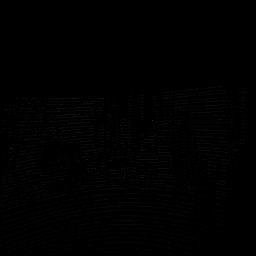

In [61]:
cv2_imshow(input_depth)

In [62]:
input_depth

array([[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 2.023, 4.094, ..., 0.   , 0.   , 0.   ],
       [0.   , 1.355, 0.   , ..., 0.   , 0.   , 0.   ]], dtype=float16)

In [ ]:
for idx in range(len(xt)):
    tensor = xt[-1].clone()
    tensor = tensor_to_depth(tensor, DEPTH_MEAN, DEPTH_STD)
    tensor = tensor.squeeze(0)
    tensor = tensor.to(torch.int64)
    mask = tensor <= 0
    result = tensor[mask] * 0
    tensor[mask] = result
    array = tensor.to('cpu').numpy()
    print("timestep = {}".format(timesteps - idx))
    cv2_imshow(array)


In [75]:
input_depth = input_depth.astype(np.int64)

In [72]:
array.dtype

dtype('int64')

In [79]:
error = np.linalg.norm((array - input_depth).astype(np.float32))
error

8175.096

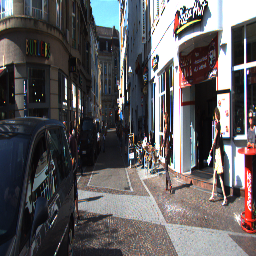

In [60]:
cv2_imshow(input_image_show)

In [ ]:
def image_loader_to_tensor(tensor):
  tensor = tensor.to(torch.float32)
  tensor = tensor / 255.0
  tensor = tensor * 2.0
  tensor = tensor - 1.0
  tensor = tensor.permute(0, 3, 1, 2)
  return tensor

In [ ]:
def tensor_to_depth(tensor, DEPTH_MEAN, DEPTH_STD):
    minus_mask = tensor == -1
    non_minus = tensor != -1
    result = tensor[non_minus] * DEPTH_STD + DEPTH_MEAN
    tensor[non_minus] = result
    tensor[minus_mask] = 0
    return tensor

In [ ]:
x1 = xt[-1].clone()
test = tensor_to_depth(x1, DEPTH_MEAN, DEPTH_STD)

In [ ]:
# checkpoint = {'test' : test}
# torch.save(checkpoint, 'first_outcome')
# source_path = 'first_outcome'
# destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data'
# # destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/drawing_loss'


# # save them to the google drive
# shutil.copy(source_path, destination_path)

In [ ]:
'''
# developing
class DiffusionModel:
    def __init__(self, beta_schedule = 'linear', start_schedule=0.0001, end_schedule=0.02, timesteps = 300):
        self.start_schedule = start_schedule
        self.end_schedule = end_schedule
        self.timesteps = timesteps

        """
        if
            betas = [0.1, 0.2, 0.3, ...]
        then
            alphas = [0.9, 0.8, 0.7, ...]
            alphas_cumprod =      [0.9, 0.9 * 0.8, 0.9 * 0.8, * 0.7, ...]
            alphas_cumprod_prev = [1,   0.9, 0.9 * 0.8, 0.9 * 0.8 * 0.7]


        """
        betas = get_beta_schedule(beta_schedule, beta_start = start_schedule, beta_end = end_schedule, num_diffusion_timesteps = timesteps)
        self.betas = torch.tensor(betas)


        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0).to(device)
        self.alphas_cumprod_prev = torch.cat(
            [torch.ones(1).to(device), self.alphas_cumprod[:-1]], dim=0
        )
    def forward(self, x_0, t, device):
        """
        x_0: (B, C, H, W)
        t: (B,)
        """


        noise = torch.randn_like(x_0)

        sqrt_alphas_cumprod_t = get_index_from_list(self.alphas_cumprod.sqrt(), t.to(torch.int64), x_0.shape)

        sqrt_one_minus_alphas_cumprod_t = get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t.to(torch.int64), x_0.shape)

        mean = sqrt_alphas_cumprod_t.to(device) * x_0.to(device)
        variance = sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

        return mean + variance, noise.to(device) # mean為x_0乘以alpha bar, variance 為 noise 乘以 1-alpha bar

    def backward_DDIM(self, model, image, weight_path, skip, eta = 0.1):
        checkpoint = torch.load(weight_path, map_location = torch.device(device))
        model.load_state_dict(checkpoint['model_state_dict'])
        with torch.inference_mode():


            # seq = range(0, timesteps, skip)   # 這是原版
            # seq_next = [-1] + list(seq[:-1])

            seq = range(1, timesteps, skip)
            seq_next = [0] + list(seq[:-1])



            # seq =      [1, 2, 3]
            # seq_next = [0, 1, 2]
            x0_preds = []
            depth = torch.randn([image.shape[0], image.shape[-1], image.shape[-1]]).to(torch.float32)
            print(depth.dtype)
            xs = [depth]
            n = image.shape[0]



            for i, j in zip(reversed(seq), reversed(seq_next)):
                t = (torch.ones(n) * i).to(image.device)
                next_t = (torch.ones(n) * j).to(image.device)

                at = self.alphas_cumprod.gather(-1, t.to(torch.int64))

                at_next = self.alphas_cumprod.gather(-1, next_t.to(torch.int64))

                xt = xs[-1].to(device) # x_t
                x0_t = model(image, xt, t, sampling = True) # episolon t (predicted)

                x0_preds.append(x0_t.to(device))
                et = (-1 * x0_t * (at.sqrt()) - xt) / (at.sqrt())
                c1 = (
                    eta * ((1 - at / at_next) * (1 - at_next) / (1 - at)).sqrt() # c1是var in the distribution, which is at ddim page 5
                                                                                                # can make the sampling process of x_{t - 1} become identical
                                                                                                # as ddpm
                )
                c2 = ((1 - at_next) - c1 ** 2).sqrt()
                xt_next = at_next.sqrt() * x0_t + c1 * torch.randn_like(x0_t) + c2 * et # 這個xt_next也是x_(t-1) 取法是ddim 裡面定義的q(x_(t-1)|x_t, x_0)
                xs.append(xt_next.to(device))
            return xs, x0_preds
    def backward_DDPM(self, model, image, weight_path): # 代入的圖片希望是(batch, 256, 256, 3) batch也可以是1 只是希望是四維的 且是tensor
        image = image.to(torch.float32).to(device)
        image = image_loader_to_tensor(image)
        checkpoint = torch.load(weight_path, map_location = torch.device(device))
        model.load_state_dict(checkpoint['model_state_dict'])
        n = image.shape[0]
        pure_noise = torch.randn((image.shape[0], image.shape[-1], image.shape[-1]))
        xt = [pure_noise]
        with torch.inference_mode():
            for i, j in zip(reversed(range(1, self.timesteps + 1)), range(0, self.timesteps)):
                noise = torch.randn((image.shape[0], image.shape[-1], image.shape[-1]))
                t = (torch.ones(n) * i).to(image.device)
                t_next = (torch.ones(n) * j).to(image.device)
                depth_tmp = xt[-1]
                ans = model(image, depth_tmp, t, sampling = True)
                betas_t = get_index_from_list(self.betas, t, depth_tmp.shape)
                sqrt_alphas = get_index_from_list(self.alphas, t, depth_tmp.shape)

                sqrt_next_alphas_cumprod = get_index_from_list(torch.sqrt(self.alphas_cumprod), t_next, depth_tmp.shape)
                one_minus_next_alphas_prod = get_index_from_list(1 - self.alphas_cumprod, t_next, depth_tmp.shape)
                one_minus_alphas_prod = get_index_from_list(1 - self.alphas_cumprod, t, depth_tmp.shape)
                xt.append((sqrt_alphas * (one_minus_next_alphas_prod) * depth_tmp + sqrt_next_alphas_cumprod * betas_t * ans) / (one_minus_alphas_prod) + betas_t * noise)
        return xt
'''

In [ ]:
'''
input_img = batch['img'].to(torch.float32).to(device)
input_img = image_loader_to_tensor(input_img)
target_depth = batch['depth'].to(torch.float32).to(device)
target_depth = depth_loader_to_tensor(target_depth, DEPTH_MEAN, DEPTH_STD)

pred_depth = model(input_img, target_depth, t)
'''

In [ ]:
'''
data_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Data/data_zip_shuffle/dataset_1.pth'
data_check = torch.load(data_path, map_location = torch.device(device))
'''

In [ ]:
# BATCH_SIZE = 256

NO_LARGE_EPOCHS = 10
save_frequency = 5
LR = 0.001
VERBOSE = False
clip_value = 1e-2
# data_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Data/data_zip_shuffle'
# name_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Data/name_zip_shuffle'
data_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/data_zip_shuffle'
name_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/name_zip_shuffle'
batch_size = 32
train_val_rate = 0.99
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
def compute_depth_mean(path):
  file_list = sorted(os.listdir(path))
  total_sum = 0

  total_nonzero = 0
  # count = 0
  for name in file_list:
    file_path = path + '/' + name
    check = torch.load(file_path)

    target = torch.tensor(check['depth_list']).to(torch.float64)
    print(target.dtype)
    total_sum += torch.sum(target)

    total_nonzero += torch.nonzero(target).size(0)
    # count += 1
    # if count == 2:
    #   break
  total_mean = total_sum / total_nonzero
  return total_sum, total_nonzero, total_mean

In [45]:
def create_dataset_large_epoch(random_list, now, data_path, name_path): #data_per_epoch / amount_from_file要是整數

  data_list = sorted(os.listdir(data_path))
  name_list = sorted(os.listdir(name_path))

  # file_idx = data_per_epoch // amount_from_file
  output_depth_path = []
  output_image_path = []
  output_depth = []
  output_image = []

  now_number = random_list[now]
  data_path = data_path + '/' + data_list[now_number]
  print(data_path)
  name_path = name_path + '/' + name_list[now_number]
  data_checkpoint = torch.load(data_path)
  name_checkpoint = torch.load(name_path)
  output_image_path = name_checkpoint['image_name']
  output_depth_path = name_checkpoint['depth_name']
  output_depth = data_checkpoint['depth_list']
  output_image = data_checkpoint['image_list']
  return output_image_path, output_depth_path, output_depth, output_image

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img, depth):
        self.img = img
        self.depth = depth


    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        sample = {'img': self.img[idx], 'depth': self.depth[idx]}
        return sample


In [61]:
def image_loader_to_tensor(tensor):
  tensor = tensor.to(torch.float32)
  tensor = tensor / 255.0
  tensor = tensor * 2.0
  tensor = tensor - 1.0
  tensor = tensor.permute(0, 3, 1, 2)
  return tensor

In [62]:
def depth_loader_to_tensor(tensor, DEPTH_MEAN, DEPTH_STD):

  nonzero_mask = tensor != 0
  zero_mask = tensor == 0
  # mean = tensor[nonzero_mask].mean()
  # std = tensor[nonzero_mask].std()
  result = (tensor[nonzero_mask] - DEPTH_MEAN) / DEPTH_STD
  tensor[nonzero_mask] = result
  tensor[zero_mask] = -1

  return tensor

In [63]:
def tensor_to_depth(tensor, DEPTH_MEAN, DEPTH_STD):
    minus_mask = tensor == -1
    non_minus = tensor != -1
    result = tensor[non_minus] * DEPTH_STD + DEPTH_MEAN
    tensor[non_minus] = result
    tensor[minus_mask] = 0
    return tensor

In [ ]:
'''
check_length = len(sorted(os.listdir(data_path)))
random_list = []
for idx in range(check_length):
    random_list.append(idx)
now = 15
output_image_path, output_depth_path, output_depth, output_image = create_dataset_large_epoch(random_list, now, data_path, name_path)
'''

'\ncheck_length = len(sorted(os.listdir(data_path)))\nrandom_list = []\nfor idx in range(check_length):\n    random_list.append(idx)\nnow = 15\noutput_image_path, output_depth_path, output_depth, output_image = create_dataset_large_epoch(random_list, now, data_path, name_path)\n'

In [ ]:
'''
print(type(output_image))
print(len(output_image))
print(type(output_image[0]))
'''

'\nprint(type(output_image))\nprint(len(output_image))\nprint(type(output_image[0]))\n'

In [ ]:
'''
custom_dataset = CustomDataset(output_image, output_depth)
print(type(custom_dataset[0]['img']))
train_size = int(train_val_rate * len(custom_dataset))
val_size = len(custom_dataset) - train_size
print(custom_dataset[0]['img'].shape)
'''

"\ncustom_dataset = CustomDataset(output_image, output_depth)\nprint(type(custom_dataset[0]['img']))\ntrain_size = int(train_val_rate * len(custom_dataset))\nval_size = len(custom_dataset) - train_size\nprint(custom_dataset[0]['img'].shape)\n"

In [ ]:
'''
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
validloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
'''

'\ntrain_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])\ntrainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)\nvalidloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last = True)\n'

In [ ]:
'''
for batch in trainloader:
    print(type(batch))
    print(batch.keys())
    print(type(batch['img']))
    print(batch['img'].shape)
    print(batch['depth'].shape)
    print(image_loader_to_tensor(batch['img']).shape)
    print(depth_loader_to_tensor(batch['depth'], DEPTH_MEAN, DEPTH_STD).shape)
    # target_depth = depth_loader_to_tensor(target_depth, DEPTH_MEAN, DEPTH_STD)
    break
'''

"\nfor batch in trainloader:\n    print(type(batch))\n    print(batch.keys())\n    print(type(batch['img']))\n    print(batch['img'].shape)\n    print(batch['depth'].shape)\n    print(image_loader_to_tensor(batch['img']).shape)\n    print(depth_loader_to_tensor(batch['depth'], DEPTH_MEAN, DEPTH_STD).shape)\n    # target_depth = depth_loader_to_tensor(target_depth, DEPTH_MEAN, DEPTH_STD)\n    break\n"

In [ ]:
'''
target_depth = batch['depth'].to(torch.float32).to(device)
print(target_depth.shape)
'''

"\ntarget_depth = batch['depth'].to(torch.float32).to(device)\nprint(target_depth.shape)\n"

In [ ]:
'''
for i, j in zip(range(1, 5), range(2, 6)):
    print(i, j)
'''

'\nfor i, j in zip(range(1, 5), range(2, 6)):\n    print(i, j)\n'

In [ ]:
class Model_optimize:
    def __init__(self, model, weight_path, loaded = False):
        if loaded == False:
            checkpoint = torch.load(weight_path, map_location=torch.device(device))
            model.load_state_dict(checkpoint['model_state_dict'])
        self.model = model
        count = 0
        for name, param in model.named_parameters():
            count += 1
        self.amount_of_param = count
    def find_a_parameter(self, target):
        list = []

        for name, param in model.named_parameters():
            par_shape = len(param.shape)
            if par_shape == 1:
                if param[0] == target:
                    list.append(name)
            elif par_shape == 2:
                if param[0][0] == target:
                    list.append(name)
            elif par_shape == 3:
                if param[0][0][0] == target:
                    list.append(name)
            elif par_shape == 4:
                if param[0][0][0][0] == target:
                    list.append(name)
        return list
    def analyst_param(self):
        for name, param in model.named_parameters():
            print('{} | {}'.format(name, param))
            print('--------------------------')
    def list_name(self):
        for name, param in model.named_parameters():
            print(name)
            print('--------------------------')
    def statics(self):
        for name, param in model.named_parameters():
            print('{} | max = {} | min = {} | mean = {}'.format(name, torch.max(param), torch.min(param), torch.mean(param)))
    def plot_name(self, name):
        for names, param in model.named_parameters():
            if names == name:
                weights_list = param.data.cpu().numpy().flatten()
                plt.figure(figsize=(7, 5))
                plt.title('Weight Distribution')
                plt.hist(weights_list, bins=50, alpha=0.7)
                plt.xlabel('Weight Value')
                plt.ylabel('Frequency')
                plt.show()

                break
    def plot_idx(self, idx):
        count = 0
        for names, param in model.named_parameters():
            if count == idx:
                weights_list = param.data.cpu().numpy().flatten()
                plt.figure(figsize=(7, 5))
                plt.title(names)
                plt.hist(weights_list, bins=50, alpha=0.7)
                plt.xlabel('Weight Value')
                plt.ylabel('Frequency')
                plt.show()

                break
            count += 1
    def plot_whole_sep(self):
        for idx in range(self.amount_of_param):
            self.plot_idx(idx)

    def plot_whole(self):
        weights_list = []
        for name, param in model.named_parameters():
            weights_list.append(param.data.cpu().numpy().flatten())
        plt.figure(figsize=(7, 5))
        plt.title('whole_plot')
        plt.hist(weights_list, bins=50, alpha=0.7)
        plt.xlabel('Weight Value')
        plt.ylabel('Frequency')
        plt.show()

In [ ]:
'''
weight_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/drawing_weight/weight_2_26.pth'
# checkpoint = torch.load(weight_path, map_location = torch.device(device))
# model.load_state_dict(checkpoint['model_state_dict'])
'''

"\nweight_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/drawing_weight/weight_2_26.pth'\n# checkpoint = torch.load(weight_path, map_location = torch.device(device))\n# model.load_state_dict(checkpoint['model_state_dict'])\n"

In [ ]:
'''
#reference mode

beta_schedule = config['diffusion']['beta_schedule']
start_schedule = config['diffusion']['beta_start']
end_schedule = config['diffusion']['beta_end']
timesteps = config['diffusion']['num_diffusion_timesteps']
diff = DiffusionModel(beta_schedule, start_schedule, end_schedule, timesteps)
model = Model(config)
model = model.to(device)
ans1, ans2 = diff.backward(model, img, weight_path, 1) # img should have 4 dimension
'''

"\n#reference mode\n\nbeta_schedule = config['diffusion']['beta_schedule']\nstart_schedule = config['diffusion']['beta_start']\nend_schedule = config['diffusion']['beta_end']\ntimesteps = config['diffusion']['num_diffusion_timesteps']\ndiff = DiffusionModel(beta_schedule, start_schedule, end_schedule, timesteps)\nmodel = Model(config)\nmodel = model.to(device)\nans1, ans2 = diff.backward(model, img, weight_path, 1) # img should have 4 dimension\n"

In [ ]:
'''
# convert back into depth map
with torch.inference_mode():
    final_ans = tensor_to_depth(depth2, DEPTH_MEAN, DEPTH_STD)
    final_ans = torch.squeeze(final_ans, dim = 0).to('cpu').numpy()
'''

"\n# convert back into depth map\nwith torch.inference_mode():\n    final_ans = tensor_to_depth(depth2, DEPTH_MEAN, DEPTH_STD)\n    final_ans = torch.squeeze(final_ans, dim = 0).to('cpu').numpy()\n"

In [ ]:

'''
data_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/data_zip'
name_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/name_zip'
load_path = ''
check_length = len(sorted(os.listdir(data_path)))
random_list = []
for idx in range(check_length):
    random_list.append(idx)
now = 15
output_image_path, output_depth_path, output_depth, output_image = create_dataset_large_epoch(random_list, now, data_path, name_path)
custom_dataset = CustomDataset(output_image, output_depth)
train_size = int(train_val_rate * len(custom_dataset))
val_size = len(custom_dataset) - train_size
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
validloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
for batch in validloader:
    input_img = batch['img'].to(torch.float32).to(device)
    input_img = image_loader_to_tensor(input_img)
    break

'''

"\ndata_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/data_zip'\nname_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/name_zip'\nload_path = ''\ncheck_length = len(sorted(os.listdir(data_path)))\nrandom_list = []\nfor idx in range(check_length):\n    random_list.append(idx)\nnow = 15\noutput_image_path, output_depth_path, output_depth, output_image = create_dataset_large_epoch(random_list, now, data_path, name_path)\ncustom_dataset = CustomDataset(output_image, output_depth)\ntrain_size = int(train_val_rate * len(custom_dataset))\nval_size = len(custom_dataset) - train_size\ntrain_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])\ntrainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)\nvalidloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last = True)\nfor batch in validloader:\n    input_img = batch['img'].to(torch.float32).to(device)\n    input_img = image_loader_

In [ ]:
# # input_img = input_img[0]
# print(input_img.shape)
# img = input_img[0]
# img = torch.unsqueeze(img, dim = 0)
# print(img.shape)
# print(img.dtype)

In [ ]:
'''
beta = get_beta_schedule(beta_schedule, beta_start = start_schedule, beta_end = end_schedule, num_diffusion_timesteps = 300)
betas = torch.tensor(beta)
alphas = 1 - betas
seq = range(0, 300, 5)
seq_next = [-1] + list(seq[:-1])
n = 1
image = img
alphas_cumprod = torch.cumprod(alphas, axis=0)
for i, j in zip(reversed(seq), reversed(seq_next)):
    t = (torch.ones(n) * i).to(image.device)
    next_t = (torch.ones(n) * j).to(image.device)
    print(t)
    at = alphas_cumprod.gather(-1, t.to(torch.int64))

    at_next = alphas_cumprod.gather(-1, next_t.to(torch.int64))

    xt = xs[-1].to(device) # x_t
    x0_t = model(image, xt, t, sampling = True) # episolon t (predicted)

    x0_preds.append(x0_t.to('cpu'))
    et = (-1 * x0_t * (at.sqrt()) - xt) / (at.sqrt())
    c1 = (
        eta * ((1 - at / at_next) * (1 - at_next) / (1 - at)).sqrt() # c1是var in the distribution, which is at ddim page 5
                                                                                    # can make the sampling process of x_{t - 1} become identical
                                                                                    # as ddpm
    )
    c2 = ((1 - at_next) - c1 ** 2).sqrt()
    xt_next = at_next.sqrt() * x0_t + c1 * torch.randn_like(x0_t) + c2 * et # 這個xt_next也是x_(t-1) 取法是ddim 裡面定義的q(x_(t-1)|x_t, x_0)
    xs.append(xt_next.to('cpu'))
    '''

"\nbeta = get_beta_schedule(beta_schedule, beta_start = start_schedule, beta_end = end_schedule, num_diffusion_timesteps = 300)\nbetas = torch.tensor(beta)\nalphas = 1 - betas\nseq = range(0, 300, 5)\nseq_next = [-1] + list(seq[:-1])\nn = 1\nimage = img\nalphas_cumprod = torch.cumprod(alphas, axis=0)\nfor i, j in zip(reversed(seq), reversed(seq_next)):\n    t = (torch.ones(n) * i).to(image.device)\n    next_t = (torch.ones(n) * j).to(image.device)\n    print(t)\n    at = alphas_cumprod.gather(-1, t.to(torch.int64))\n\n    at_next = alphas_cumprod.gather(-1, next_t.to(torch.int64))\n\n    xt = xs[-1].to(device) # x_t\n    x0_t = model(image, xt, t, sampling = True) # episolon t (predicted)\n\n    x0_preds.append(x0_t.to('cpu'))\n    et = (-1 * x0_t * (at.sqrt()) - xt) / (at.sqrt())\n    c1 = (\n        eta * ((1 - at / at_next) * (1 - at_next) / (1 - at)).sqrt() # c1是var in the distribution, which is at ddim page 5\n                                                                       

In [ ]:

#debug epoch

epoch = 0
data_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/data_zip'
name_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/name_zip'
# data_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Data/data_zip_shuffle'
# name_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Data/name_zip_shuffle'
check_length = len(sorted(os.listdir(data_path)))
random_list = []
for idx in range(check_length):
    random_list.append(idx)
now = 15
output_image_path, output_depth_path, output_depth, output_image = create_dataset_large_epoch(random_list, now, data_path, name_path)
custom_dataset = CustomDataset(output_image, output_depth)
train_size = int(train_val_rate * len(custom_dataset))
val_size = len(custom_dataset) - train_size
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
validloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
for large_epoch in range(1, NO_LARGE_EPOCHS + 1):



    for now in range(check_length): # 一個小epoch是一個checkpoint檔，紀錄一次

        epoch += 1



        start_time = time.time()
        mean_epoch_loss = []
        mean_epoch_loss_val = []
        epoch_gradient = {}
        for batch in trainloader:
            t = torch.randint(0, config['diffusion']['num_diffusion_timesteps'], (batch_size,)).long().to(device)

            input_img = batch['img'].to(torch.float32).to(device)
            input_img = image_loader_to_tensor(input_img)
            target_depth = batch['depth'].to(torch.float32).to(device)
            target_depth = depth_loader_to_tensor(target_depth, DEPTH_MEAN, DEPTH_STD)

            pred_depth = model(input_img, target_depth, t)
            # --------------------exit--------
            # sys.exit()
            # --------------------exit--------

            optimizer.zero_grad()
            loss = torch.nn.functional.mse_loss(target_depth, pred_depth)
            # params = list(model.parameters())
            # weight_tensor = params[490]
            # chains = torch.autograd.grad(loss, weight_tensor, retain_graph=True)
            # for chain in chains:
            #     print(chain)
            mean_epoch_loss.append(loss.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            # for param in model.parameters():
            #     if param.grad is not None:
            #         param.grad.data.clamp_(-clip_value, clip_value)
            optimizer.step()
            #---gradient---vvv
            for name, param in model.named_parameters():
                if param.grad == None:
                    epoch_gradient[name + 'zero'] = 1
                elif name not in epoch_gradient:
                    epoch_gradient[name] = param.grad.clone()
                else:
                    epoch_gradient[name] += param.grad
            #---gradient---^^^
        with torch.inference_mode():
            for batch in validloader:
                t = torch.randint(0, config['diffusion']['num_diffusion_timesteps'], (batch_size,)).long().to(device)
                input_img = batch['img'].to(torch.float32).to(device)

                input_img = image_loader_to_tensor(input_img)
                target_depth = batch['depth'].to(torch.float32).to(device)
                target_depth = depth_loader_to_tensor(target_depth, DEPTH_MEAN, DEPTH_STD)
                pred_depth = model(input_img, target_depth, t)

                val_loss = torch.nn.functional.mse_loss(target_depth, pred_depth)
                mean_epoch_loss_val.append(val_loss.item())

        if epoch % save_frequency == 0 or epoch == check_length * NO_LARGE_EPOCHS:
            checkpoint = {
                'large_epoch' : large_epoch,
                'epoch': epoch,
                'model_state_dict': model.state_dict(), # model.state_dict()是存下param的的值和形狀
                'optimizer_state_dict': optimizer.state_dict(), # optimizer.state_dict()則是存下優化器的param如momentum等等 不包含當下梯度
                'valid_loss' : np.mean(mean_epoch_loss_val),
                'loss' : np.mean(mean_epoch_loss), # 記得不能存tensor
                'now' : now,
                'random_list' : random_list,
                'gradients' : epoch_gradient
            }

            torch.save(checkpoint, 'weight_{}_{}.pth'.format(large_epoch, epoch))
            source_path = 'weight_{}_{}.pth'.format(large_epoch, epoch)
            destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/take_out_normal_weight7'
            # destination_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Checkpoint/take_out_normal_weight'


            # save them to the google drive
            shutil.copy(source_path, destination_path)

        #---計算時間---vvv
        end_time = time.time()
        exe_time = end_time - start_time
        hours, remainder = divmod(exe_time, 3600)
        minutes, seconds = divmod(remainder, 60)
        #---計算時間---^^^

        #-----以下是存loss的---vvv
        checkpoint = {
        'large_epoch' : large_epoch,
        'epoch': epoch,
        'valid_loss' : np.mean(mean_epoch_loss_val),
        'loss' : np.mean(mean_epoch_loss), # 記得不能存tensor
        'time' : exe_time
        }

        torch.save(checkpoint, 'loss_{}_{}.pth'.format(large_epoch, epoch))
        source_path = 'loss_{}_{}.pth'.format(large_epoch, epoch)
        destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/take_out_normal_loss7'
        # destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/drawing_loss'


        # save them to the google drive
        shutil.copy(source_path, destination_path)
        #-----以下是存loss的---^^^

        print('---')
        print(f"Large Epoch: {large_epoch}, Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        print("time = {}:{}:{}".format(int(hours), int(minutes), int(seconds)))



---
Large Epoch: 1, Epoch: 1 | Train Loss 0.29184980409872996 | Val Loss 0.20557904243469238
time = 0:0:49
---
Large Epoch: 1, Epoch: 2 | Train Loss 0.1850032839295152 | Val Loss 0.15146948397159576
time = 0:0:46
---
Large Epoch: 1, Epoch: 3 | Train Loss 0.15559467861985232 | Val Loss 0.12507903575897217
time = 0:0:46
---
Large Epoch: 1, Epoch: 4 | Train Loss 0.1400088547886192 | Val Loss 0.13470077514648438
time = 0:0:46
---
Large Epoch: 1, Epoch: 5 | Train Loss 0.131911263740682 | Val Loss 0.11882348358631134
time = 0:0:53
---
Large Epoch: 1, Epoch: 6 | Train Loss 0.12366859218129864 | Val Loss 0.1435292661190033
time = 0:0:46
---
Large Epoch: 1, Epoch: 7 | Train Loss 0.11564378372647545 | Val Loss 0.09323053807020187
time = 0:0:46
---
Large Epoch: 1, Epoch: 8 | Train Loss 0.11122386520365615 | Val Loss 0.09870825707912445
time = 0:0:46
---
Large Epoch: 1, Epoch: 9 | Train Loss 0.10549698784560352 | Val Loss 0.11323845386505127
time = 0:0:46
---
Large Epoch: 1, Epoch: 10 | Train Loss

KeyboardInterrupt: 

In [ ]:

#debug epoch continue
large_epoch = 4
epoch = 65
data_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/data_zip'
name_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Data/name_zip'
load_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/take_out_normal_weight8/weight_{}_{}.pth'.format(large_epoch, epoch)
# load_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Checkpoint/drawing_weight2/weight_{}_{}.pth'.format(large_epoch, epoch)
check_length = len(sorted(os.listdir(data_path)))
random_list = []
for idx in range(check_length):
    random_list.append(idx)
now = 15
output_image_path, output_depth_path, output_depth, output_image = create_dataset_large_epoch(random_list, now, data_path, name_path)
custom_dataset = CustomDataset(output_image, output_depth)
train_size = int(train_val_rate * len(custom_dataset))
val_size = len(custom_dataset) - train_size
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
validloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last = True)

checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])



for large_epoch in range(large_epoch, NO_LARGE_EPOCHS + 1):



    while True: # 一個小epoch是一個checkpoint檔，紀錄一次
        current_lr = optimizer.param_groups[0]['lr']
        print('lr : {}'.format(current_lr))
        sym = 0
        epoch += 1

        start_time = time.time()
        mean_epoch_loss = []
        mean_epoch_loss_val = []
        epoch_gradient = {}

        if sym == 1:
            sym = 1
            for param_group in optimizer.param_groups:
                param_group['lr'] = 0.0001


        for batch in trainloader:
            # current_lr = optimizer.param_groups[0]['lr']
            # print('lr : {}'.format(current_lr))
            t = torch.randint(0, config['diffusion']['num_diffusion_timesteps'], (batch_size,)).long().to(device)

            input_img = batch['img'].to(torch.float32).to(device)
            input_img = image_loader_to_tensor(input_img)
            target_depth = batch['depth'].to(torch.float32).to(device)
            target_depth = depth_loader_to_tensor(target_depth, DEPTH_MEAN, DEPTH_STD)

            pred_depth = model(input_img, target_depth, t)

            optimizer.zero_grad()
            loss = torch.nn.functional.mse_loss(target_depth, pred_depth)
            mean_epoch_loss.append(loss.item())
            loss.backward()
            for param in model.parameters():
                if param.grad is not None:
                    param.grad.data.clamp_(-clip_value, clip_value)
            optimizer.step()




            #---gradient---vvv
            for name, param in model.named_parameters():
                if param.grad == None:
                    epoch_gradient[name + 'zero'] = 1
                elif name not in epoch_gradient:
                    epoch_gradient[name] = param.grad.clone()
                else:
                    epoch_gradient[name] += param.grad
            #---gradient---^^^
        with torch.inference_mode():
            for batch in validloader:
                t = torch.randint(0, config['diffusion']['num_diffusion_timesteps'], (batch_size,)).long().to(device)
                input_img = batch['img'].to(torch.float32).to(device)

                input_img = image_loader_to_tensor(input_img)
                target_depth = batch['depth'].to(torch.float32).to(device)
                target_depth = depth_loader_to_tensor(target_depth, DEPTH_MEAN, DEPTH_STD)
                pred_depth = model(input_img, target_depth, t)

                val_loss = torch.nn.functional.mse_loss(target_depth, pred_depth)
                mean_epoch_loss_val.append(val_loss.item())

        if epoch % save_frequency == 0 or epoch == check_length * NO_LARGE_EPOCHS:
            checkpoint = {
                'large_epoch' : large_epoch,
                'epoch': epoch,
                'model_state_dict': model.state_dict(), # model.state_dict()是存下param的的值和形狀
                'optimizer_state_dict': optimizer.state_dict(), # optimizer.state_dict()則是存下優化器的param如momentum等等 不包含當下梯度
                'valid_loss' : np.mean(mean_epoch_loss_val),
                'loss' : np.mean(mean_epoch_loss), # 記得不能存tensor
                'now' : now,
                'random_list' : random_list,
                'gradients' : epoch_gradient
            }

            torch.save(checkpoint, 'weight_{}_{}.pth'.format(large_epoch, epoch))
            source_path = 'weight_{}_{}.pth'.format(large_epoch, epoch)
            # destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/drawing_weight'
            # destination_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Checkpoint/model1_weight'
            # destination_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Checkpoint/drawing_weight2'
            destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/take_out_normal_weight8'


            # save them to the google drive
            shutil.copy(source_path, destination_path)

        #---計算時間---vvv
        end_time = time.time()
        exe_time = end_time - start_time
        hours, remainder = divmod(exe_time, 3600)
        minutes, seconds = divmod(remainder, 60)
        #---計算時間---^^^

        #-----以下是存loss的---vvv
        checkpoint = {
        'large_epoch' : large_epoch,
        'epoch': epoch,
        'valid_loss' : np.mean(mean_epoch_loss_val),
        'loss' : np.mean(mean_epoch_loss), # 記得不能存tensor
        'time' : exe_time
        }

        torch.save(checkpoint, 'loss_{}_{}.pth'.format(large_epoch, epoch))
        source_path = 'loss_{}_{}.pth'.format(large_epoch, epoch)
        # destination_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Checkpoint/model1_loss'
        # destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/drawing_loss'
        # destination_path = '/content/drive/MyDrive/Colab Notebooks/共用區/Simple_DE/Checkpoint/drawing_loss2'
        destination_path = '/content/drive/MyDrive/Colab Notebooks/Simple_DE/Checkpoint/take_out_normal_loss8'


        # save them to the google drive
        shutil.copy(source_path, destination_path)
        #-----以下是存loss的---^^^

        print('---')
        print(f"Large Epoch: {large_epoch}, Epoch: {epoch} | Train Loss {np.mean(mean_epoch_loss)} | Val Loss {np.mean(mean_epoch_loss_val)}")
        print("time = {}:{}:{}".format(int(hours), int(minutes), int(seconds)))

        if epoch % 18 == 0:
            break


lr : 0.001
---
Large Epoch: 4, Epoch: 66 | Train Loss 0.026631550966193535 | Val Loss 0.029962994158267975
time = 0:0:48
lr : 0.001
---
Large Epoch: 4, Epoch: 67 | Train Loss 0.027051405134526165 | Val Loss 0.026147669181227684
time = 0:0:45
lr : 0.001
---
Large Epoch: 4, Epoch: 68 | Train Loss 0.026510758639930132 | Val Loss 0.027488339692354202
time = 0:0:45
lr : 0.001
---
Large Epoch: 4, Epoch: 69 | Train Loss 0.026436805912571682 | Val Loss 0.02793242037296295
time = 0:0:45
lr : 0.001
---
Large Epoch: 4, Epoch: 70 | Train Loss 0.026062534051620727 | Val Loss 0.025394488126039505
time = 0:0:55
lr : 0.001
---
Large Epoch: 4, Epoch: 71 | Train Loss 0.024966508694380135 | Val Loss 0.032377563416957855
time = 0:0:45
lr : 0.001
---
Large Epoch: 4, Epoch: 72 | Train Loss 0.02560721579697225 | Val Loss 0.014377377927303314
time = 0:0:45
lr : 0.001
---
Large Epoch: 5, Epoch: 73 | Train Loss 0.024262955351793146 | Val Loss 0.03293812274932861
time = 0:0:45
lr : 0.001
---
Large Epoch: 5, Epoc

In [ ]:
from google.colab import runtime
runtime.unassign()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
